MOUNT THE DRIVE AND LOAD THE DATASET

In [1]:
#save test set predictions to a file
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

In [3]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "../harmonies_database"

In [4]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls ../harmonies_database

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
analog/  rectangle/


In [6]:
from torch.utils.data import Dataset
import numpy as np

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = torch.Tensor(np.moveaxis(np.array(Image.open(zebra_path)),-1,0)).to(torch.device("cuda:0"))/255
        horse_img = torch.Tensor(np.moveaxis(np.array(Image.open(horse_path)),-1,0)).to(torch.device("cuda:0"))/255


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"analog"),os.path.join(root_data,"rectangle"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'analog')

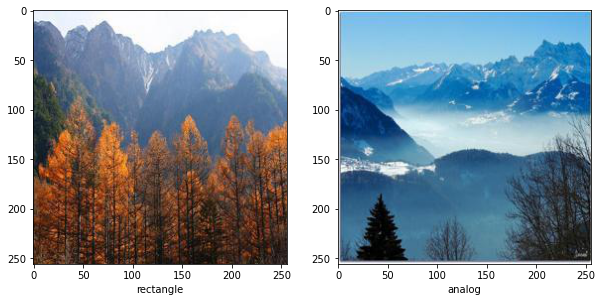

In [7]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.xlabel("analog")

#MODELS

In [8]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [9]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [10]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            Block-14          [-1, 512,

In [11]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [12]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [13]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [14]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

tensor([[[ 0.3526,  0.8425,  0.7326,  ...,  0.5635, -0.5660, -0.3956],
         [ 0.7698,  0.6352,  0.8746,  ...,  0.0858,  0.5502,  0.2063],
         [ 0.6734,  0.8670,  0.7968,  ...,  0.8883,  0.2756,  0.1861],
         ...,
         [ 0.3686,  0.4703,  0.2964,  ...,  0.1629, -0.0501,  0.0431],
         [ 0.5642,  0.3915,  0.4219,  ...,  0.4480,  0.3782,  0.4614],
         [ 0.4019,  0.3760,  0.0737,  ...,  0.2645,  0.5017,  0.1753]],

        [[ 0.6578,  0.8761,  0.2768,  ..., -0.1823,  0.4808,  0.7086],
         [-0.4274, -0.5645,  0.5840,  ..., -0.1019,  0.0509,  0.4467],
         [ 0.1122, -0.2047,  0.3831,  ..., -0.2661,  0.8209, -0.1459],
         ...,
         [ 0.0053,  0.1196,  0.1119,  ...,  0.1175,  0.1567,  0.1370],
         [ 0.1506,  0.2252,  0.0264,  ...,  0.2072,  0.0232,  0.2420],
         [ 0.1911,  0.1694, -0.0853,  ...,  0.2616,  0.1154,  0.1897]],

        [[ 0.7534,  0.9325,  0.8688,  ...,  0.4525,  0.2883,  0.7109],
         [ 0.8232,  0.4044,  0.9102,  ..., -0

In [15]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [16]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
        loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

        #adversarial loss for winter discriminator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
        loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

        #final D loss
        D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


      opt_d.zero_grad()
      D_loss.backward()
      opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_S(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [17]:
#disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

  3%|▎         | 16/562 [00:07<03:25,  2.66it/s]

Gloss adv :  5.108527660369873 Gloss adv :  0.6421846151351929 D loss :  0.4228191673755646


  6%|▌         | 31/562 [00:12<02:46,  3.18it/s]

Gloss adv :  3.4381892681121826 Gloss adv :  0.6805236339569092 D loss :  0.3966629207134247


  8%|▊         | 46/562 [00:16<02:25,  3.54it/s]

Gloss adv :  3.1547489166259766 Gloss adv :  0.6464334726333618 D loss :  0.44516870379447937


 11%|█         | 61/562 [00:21<02:21,  3.54it/s]

Gloss adv :  3.2684860229492188 Gloss adv :  0.569214403629303 D loss :  0.463710755109787


 14%|█▎        | 76/562 [00:25<02:20,  3.45it/s]

Gloss adv :  3.4502387046813965 Gloss adv :  0.6779484152793884 D loss :  0.4034119248390198


 16%|█▌        | 91/562 [00:29<02:07,  3.69it/s]

Gloss adv :  3.746124267578125 Gloss adv :  0.6579676866531372 D loss :  0.40639978647232056


 19%|█▉        | 106/562 [00:33<02:18,  3.29it/s]

Gloss adv :  3.0515291690826416 Gloss adv :  0.6821542978286743 D loss :  0.4178963303565979


 22%|██▏       | 121/562 [00:38<02:09,  3.40it/s]

Gloss adv :  3.37326717376709 Gloss adv :  0.6677263379096985 D loss :  0.4220885634422302


 24%|██▍       | 136/562 [00:42<02:04,  3.42it/s]

Gloss adv :  3.267387866973877 Gloss adv :  0.7132965326309204 D loss :  0.40124768018722534


 27%|██▋       | 151/562 [00:47<02:07,  3.23it/s]

Gloss adv :  2.662997245788574 Gloss adv :  0.7725577354431152 D loss :  0.41029787063598633


 30%|██▉       | 166/562 [00:51<01:54,  3.45it/s]

Gloss adv :  1.9200109243392944 Gloss adv :  0.7563780546188354 D loss :  0.3477827310562134


 32%|███▏      | 181/562 [00:55<01:55,  3.31it/s]

Gloss adv :  2.7076587677001953 Gloss adv :  0.6274511814117432 D loss :  0.4537966251373291


 35%|███▍      | 196/562 [01:00<01:38,  3.73it/s]

Gloss adv :  2.2655444145202637 Gloss adv :  0.750931978225708 D loss :  0.4005815088748932


 38%|███▊      | 211/562 [01:03<01:36,  3.63it/s]

Gloss adv :  2.5015931129455566 Gloss adv :  0.7055320739746094 D loss :  0.39600297808647156


 40%|████      | 226/562 [01:08<01:41,  3.30it/s]

Gloss adv :  3.9800357818603516 Gloss adv :  0.7292318344116211 D loss :  0.394417941570282


 43%|████▎     | 241/562 [01:12<01:30,  3.54it/s]

Gloss adv :  2.5882129669189453 Gloss adv :  0.8604332208633423 D loss :  0.28757864236831665


 46%|████▌     | 256/562 [01:16<01:35,  3.20it/s]

Gloss adv :  1.804755687713623 Gloss adv :  0.8203462362289429 D loss :  0.3778800368309021


 48%|████▊     | 271/562 [01:20<01:20,  3.60it/s]

Gloss adv :  2.118694305419922 Gloss adv :  0.7434338331222534 D loss :  0.3918498754501343


 51%|█████     | 286/562 [01:26<02:03,  2.24it/s]

Gloss adv :  2.1793742179870605 Gloss adv :  0.716764509677887 D loss :  0.37873169779777527


 54%|█████▎    | 301/562 [01:30<01:16,  3.43it/s]

Gloss adv :  2.9926247596740723 Gloss adv :  0.8370734453201294 D loss :  0.29999521374702454


 56%|█████▌    | 316/562 [01:36<01:20,  3.05it/s]

Gloss adv :  2.5414257049560547 Gloss adv :  0.788062334060669 D loss :  0.3979673385620117


 59%|█████▉    | 331/562 [01:40<01:03,  3.63it/s]

Gloss adv :  2.727646589279175 Gloss adv :  0.827630877494812 D loss :  0.3595302700996399


 62%|██████▏   | 346/562 [01:44<01:08,  3.18it/s]

Gloss adv :  2.613955020904541 Gloss adv :  0.8786479830741882 D loss :  0.30616721510887146


 64%|██████▍   | 361/562 [01:49<00:59,  3.38it/s]

Gloss adv :  1.5176153182983398 Gloss adv :  0.7684780359268188 D loss :  0.3647010028362274


 67%|██████▋   | 376/562 [01:53<00:54,  3.39it/s]

Gloss adv :  2.5356669425964355 Gloss adv :  0.750859260559082 D loss :  0.3752478361129761


 70%|██████▉   | 391/562 [01:57<00:46,  3.71it/s]

Gloss adv :  2.2199578285217285 Gloss adv :  0.8306853175163269 D loss :  0.41656315326690674


 72%|███████▏  | 406/562 [02:01<00:40,  3.87it/s]

Gloss adv :  2.3738884925842285 Gloss adv :  0.7719197273254395 D loss :  0.2988755404949188


 75%|███████▍  | 421/562 [02:06<00:41,  3.38it/s]

Gloss adv :  2.86879825592041 Gloss adv :  0.904654860496521 D loss :  0.28926610946655273


 78%|███████▊  | 436/562 [02:10<00:36,  3.47it/s]

Gloss adv :  2.84696626663208 Gloss adv :  0.902967631816864 D loss :  0.35708072781562805


 80%|████████  | 451/562 [02:14<00:28,  3.88it/s]

Gloss adv :  2.4372808933258057 Gloss adv :  0.9458197355270386 D loss :  0.29748350381851196


 83%|████████▎ | 466/562 [02:18<00:26,  3.68it/s]

Gloss adv :  2.3080224990844727 Gloss adv :  0.8836243748664856 D loss :  0.3687063455581665


 86%|████████▌ | 481/562 [02:23<00:24,  3.27it/s]

Gloss adv :  2.632875919342041 Gloss adv :  0.829765796661377 D loss :  0.38590192794799805


 88%|████████▊ | 496/562 [02:27<00:19,  3.45it/s]

Gloss adv :  2.7832493782043457 Gloss adv :  0.9325723052024841 D loss :  0.2802720367908478


 91%|█████████ | 511/562 [02:31<00:14,  3.42it/s]

Gloss adv :  2.7623887062072754 Gloss adv :  0.8010109663009644 D loss :  0.4490744471549988


 94%|█████████▎| 526/562 [02:36<00:10,  3.29it/s]

Gloss adv :  2.1001040935516357 Gloss adv :  1.0724459886550903 D loss :  0.30678385496139526


 96%|█████████▋| 541/562 [02:40<00:05,  3.75it/s]

Gloss adv :  1.7379757165908813 Gloss adv :  0.9032913446426392 D loss :  0.35337838530540466


 99%|█████████▉| 556/562 [02:44<00:01,  3.56it/s]

Gloss adv :  2.177670955657959 Gloss adv :  0.858979344367981 D loss :  0.36926329135894775


571it [02:46,  8.40it/s]

Gloss adv :  2.2264175415039062 Gloss adv :  0.9413504600524902 D loss :  0.35723474621772766


587it [02:48, 10.20it/s]

Gloss adv :  2.368558883666992 Gloss adv :  0.7730025053024292 D loss :  0.5456832647323608


601it [02:49, 10.18it/s]

Gloss adv :  2.304929733276367 Gloss adv :  0.7697470188140869 D loss :  0.4946928024291992


617it [02:51, 10.24it/s]

Gloss adv :  2.53587007522583 Gloss adv :  0.7994222640991211 D loss :  0.38231104612350464


631it [02:52, 10.07it/s]

Gloss adv :  2.242781162261963 Gloss adv :  0.7459357380867004 D loss :  0.48699742555618286


647it [02:54, 10.17it/s]

Gloss adv :  1.918196439743042 Gloss adv :  0.705873429775238 D loss :  0.5992691516876221


661it [02:55, 10.10it/s]

Gloss adv :  1.9155113697052002 Gloss adv :  0.8497316241264343 D loss :  0.4436319172382355


677it [02:57, 10.21it/s]

Gloss adv :  2.039707660675049 Gloss adv :  0.7421919107437134 D loss :  0.5137526988983154


691it [02:58, 10.09it/s]

Gloss adv :  2.029871940612793 Gloss adv :  0.6542681455612183 D loss :  0.5583049058914185


707it [03:00, 10.10it/s]

Gloss adv :  2.377983570098877 Gloss adv :  0.7632458209991455 D loss :  0.44055208563804626


721it [03:01, 10.03it/s]

Gloss adv :  2.335505723953247 Gloss adv :  0.7764050960540771 D loss :  0.38852962851524353


737it [03:03, 10.13it/s]

Gloss adv :  2.7901196479797363 Gloss adv :  0.7337064743041992 D loss :  0.40914928913116455


751it [03:04,  9.98it/s]

Gloss adv :  2.8299784660339355 Gloss adv :  0.8704735636711121 D loss :  0.33978086709976196


767it [03:06, 10.07it/s]

Gloss adv :  1.658595085144043 Gloss adv :  0.7155968546867371 D loss :  0.45846742391586304


781it [03:07, 10.00it/s]

Gloss adv :  2.632012128829956 Gloss adv :  0.7106713056564331 D loss :  0.3857089877128601


797it [03:09, 10.05it/s]

Gloss adv :  2.491570234298706 Gloss adv :  0.6210024356842041 D loss :  0.5166093707084656


811it [03:10, 10.00it/s]

Gloss adv :  1.5584025382995605 Gloss adv :  0.8523690104484558 D loss :  0.32217416167259216


827it [03:12, 10.08it/s]

Gloss adv :  2.0430526733398438 Gloss adv :  0.9058336019515991 D loss :  0.2954370379447937


841it [03:13,  9.91it/s]

Gloss adv :  1.9358148574829102 Gloss adv :  0.8693555593490601 D loss :  0.33632293343544006


857it [03:15, 10.05it/s]

Gloss adv :  2.3520843982696533 Gloss adv :  0.7489653825759888 D loss :  0.4623018801212311


871it [03:16,  9.84it/s]

Gloss adv :  4.540552139282227 Gloss adv :  0.5968506336212158 D loss :  0.548491358757019


887it [03:18, 10.00it/s]

Gloss adv :  1.927286982536316 Gloss adv :  0.8188828229904175 D loss :  0.4069267511367798


902it [03:19,  9.95it/s]

Gloss adv :  2.066662073135376 Gloss adv :  0.7401716709136963 D loss :  0.37846988439559937


916it [03:21,  9.97it/s]

Gloss adv :  2.6894583702087402 Gloss adv :  0.8293502926826477 D loss :  0.3614264130592346


931it [03:22,  9.86it/s]

Gloss adv :  2.09493088722229 Gloss adv :  0.6724230051040649 D loss :  0.4663483500480652


947it [03:24,  9.98it/s]

Gloss adv :  2.617617130279541 Gloss adv :  0.7691357731819153 D loss :  0.3550536036491394


961it [03:25,  9.99it/s]

Gloss adv :  2.117757797241211 Gloss adv :  0.783913254737854 D loss :  0.3389071226119995


977it [03:27, 10.03it/s]

Gloss adv :  2.8843955993652344 Gloss adv :  0.7531492710113525 D loss :  0.44469159841537476


991it [03:28,  9.95it/s]

Gloss adv :  1.466081976890564 Gloss adv :  0.7160661220550537 D loss :  0.49356454610824585


1007it [03:30, 10.00it/s]

Gloss adv :  2.092562675476074 Gloss adv :  0.6819502115249634 D loss :  0.48878249526023865


1021it [03:31,  9.84it/s]

Gloss adv :  2.062744140625 Gloss adv :  0.8606601357460022 D loss :  0.27253615856170654


1036it [03:33,  9.85it/s]

Gloss adv :  2.782722234725952 Gloss adv :  0.7794697284698486 D loss :  0.3498058021068573


1052it [03:34, 10.03it/s]

Gloss adv :  1.8228613138198853 Gloss adv :  0.8180984258651733 D loss :  0.4372307062149048


1066it [03:36,  9.87it/s]

Gloss adv :  2.5082790851593018 Gloss adv :  0.786953866481781 D loss :  0.33211490511894226


1082it [03:37, 10.02it/s]

Gloss adv :  2.4803307056427 Gloss adv :  0.7112724781036377 D loss :  0.46808484196662903


1096it [03:38,  9.93it/s]

Gloss adv :  1.748725175857544 Gloss adv :  0.6848726272583008 D loss :  0.44014617800712585


1112it [03:40, 10.07it/s]

Gloss adv :  3.1895036697387695 Gloss adv :  0.764864981174469 D loss :  0.3454941511154175


1126it [03:41,  9.96it/s]

Gloss adv :  1.8364460468292236 Gloss adv :  0.8909059762954712 D loss :  0.38262325525283813


1142it [03:43, 10.11it/s]

Gloss adv :  1.6946018934249878 Gloss adv :  0.8482754230499268 D loss :  0.36572158336639404


1156it [03:44,  9.97it/s]

Gloss adv :  1.5851109027862549 Gloss adv :  0.7609922885894775 D loss :  0.4895705580711365


1172it [03:46, 10.14it/s]

Gloss adv :  1.8911585807800293 Gloss adv :  0.7063208222389221 D loss :  0.4152800142765045


1186it [03:47,  9.98it/s]

Gloss adv :  2.148271083831787 Gloss adv :  0.6792064905166626 D loss :  0.46869102120399475


1202it [03:49, 10.14it/s]

Gloss adv :  1.9773123264312744 Gloss adv :  0.7817569375038147 D loss :  0.4203099012374878


1216it [03:50,  9.99it/s]

Gloss adv :  2.1452503204345703 Gloss adv :  0.8282887935638428 D loss :  0.35157057642936707


1232it [03:52, 10.16it/s]

Gloss adv :  2.241919755935669 Gloss adv :  0.7782237529754639 D loss :  0.5266438722610474


1246it [03:53, 10.03it/s]

Gloss adv :  1.8108395338058472 Gloss adv :  0.7946665287017822 D loss :  0.34862202405929565


1262it [03:55, 10.16it/s]

Gloss adv :  1.8983322381973267 Gloss adv :  0.7047632932662964 D loss :  0.41018396615982056


1276it [03:56, 10.05it/s]

Gloss adv :  3.3242106437683105 Gloss adv :  0.8526428937911987 D loss :  0.33189454674720764


1292it [03:58, 10.12it/s]

Gloss adv :  2.266421318054199 Gloss adv :  0.7803188562393188 D loss :  0.41865625977516174


1306it [03:59, 10.00it/s]

Gloss adv :  2.164865016937256 Gloss adv :  0.855151891708374 D loss :  0.30481427907943726


1322it [04:01, 10.16it/s]

Gloss adv :  2.0431137084960938 Gloss adv :  0.8486237525939941 D loss :  0.29685211181640625


1336it [04:02,  9.98it/s]

Gloss adv :  1.3862812519073486 Gloss adv :  0.7830792665481567 D loss :  0.39768943190574646


1352it [04:04, 10.16it/s]

Gloss adv :  1.710573434829712 Gloss adv :  0.8496766090393066 D loss :  0.27964234352111816


1366it [04:05, 10.04it/s]

Gloss adv :  1.4716120958328247 Gloss adv :  0.8592529296875 D loss :  0.33845430612564087


1382it [04:07, 10.19it/s]

Gloss adv :  1.7072834968566895 Gloss adv :  0.7674033641815186 D loss :  0.4695202708244324


1396it [04:08, 10.07it/s]

Gloss adv :  2.059248447418213 Gloss adv :  0.6723678112030029 D loss :  0.511121928691864


1412it [04:10, 10.15it/s]

Gloss adv :  1.7094476222991943 Gloss adv :  0.7825524806976318 D loss :  0.39206019043922424


1426it [04:11, 10.07it/s]

Gloss adv :  2.0540413856506348 Gloss adv :  0.9009355902671814 D loss :  0.32759419083595276


1442it [04:13, 10.20it/s]

Gloss adv :  1.7710888385772705 Gloss adv :  0.8021223545074463 D loss :  0.40432053804397583


1456it [04:14, 10.08it/s]

Gloss adv :  2.4125611782073975 Gloss adv :  0.8975750803947449 D loss :  0.33261746168136597


1472it [04:16, 10.13it/s]

Gloss adv :  1.9895715713500977 Gloss adv :  0.8559818267822266 D loss :  0.4021051824092865


1486it [04:17, 10.07it/s]

Gloss adv :  2.997741460800171 Gloss adv :  0.7734708786010742 D loss :  0.34464070200920105


1502it [04:19, 10.11it/s]

Gloss adv :  1.6242810487747192 Gloss adv :  0.8614853620529175 D loss :  0.27495282888412476


1516it [04:20, 10.08it/s]

Gloss adv :  1.914066195487976 Gloss adv :  0.9262208938598633 D loss :  0.368374764919281


1532it [04:21, 10.11it/s]

Gloss adv :  1.7089216709136963 Gloss adv :  0.84062659740448 D loss :  0.36371150612831116


1546it [04:23,  9.98it/s]

Gloss adv :  1.200425148010254 Gloss adv :  0.9471312761306763 D loss :  0.31435611844062805


1562it [04:24,  9.96it/s]

Gloss adv :  1.3112512826919556 Gloss adv :  0.8144991397857666 D loss :  0.34919917583465576


1576it [04:26, 10.01it/s]

Gloss adv :  2.0567100048065186 Gloss adv :  0.7669737935066223 D loss :  0.42042019963264465


1592it [04:27, 10.14it/s]

Gloss adv :  2.319847822189331 Gloss adv :  0.8299100995063782 D loss :  0.40842747688293457


1606it [04:29, 10.05it/s]

Gloss adv :  1.967301607131958 Gloss adv :  0.8290829658508301 D loss :  0.4036598801612854


1622it [04:30, 10.14it/s]

Gloss adv :  1.2920546531677246 Gloss adv :  0.9413073062896729 D loss :  0.3030969500541687


1636it [04:32,  9.99it/s]

Gloss adv :  1.7342946529388428 Gloss adv :  0.7701011896133423 D loss :  0.3651539087295532


1652it [04:33, 10.13it/s]

Gloss adv :  1.807079553604126 Gloss adv :  0.8676722049713135 D loss :  0.39785200357437134


1666it [04:35, 10.03it/s]

Gloss adv :  1.5945364236831665 Gloss adv :  0.9774398803710938 D loss :  0.41864821314811707


1682it [04:36, 10.11it/s]

Gloss adv :  2.083199977874756 Gloss adv :  0.7608075141906738 D loss :  0.3102315664291382


1696it [04:38,  9.95it/s]

Gloss adv :  1.6921405792236328 Gloss adv :  0.9009275436401367 D loss :  0.38052064180374146


1712it [04:39, 10.16it/s]

Gloss adv :  1.675222396850586 Gloss adv :  0.8687134981155396 D loss :  0.42632949352264404


1726it [04:41, 10.00it/s]

Gloss adv :  1.951364278793335 Gloss adv :  0.9613173604011536 D loss :  0.291117787361145


1742it [04:42, 10.10it/s]

Gloss adv :  1.7337968349456787 Gloss adv :  0.8965407609939575 D loss :  0.3850356638431549


1756it [04:44, 10.03it/s]

Gloss adv :  2.49113392829895 Gloss adv :  0.8735805153846741 D loss :  0.33094120025634766


1772it [04:45, 10.11it/s]

Gloss adv :  1.8791958093643188 Gloss adv :  0.7525736093521118 D loss :  0.4448552429676056


1786it [04:47,  9.94it/s]

Gloss adv :  1.626760482788086 Gloss adv :  0.9133087396621704 D loss :  0.3591129779815674


1802it [04:48, 10.13it/s]

Gloss adv :  1.7101958990097046 Gloss adv :  0.7717726230621338 D loss :  0.4744533896446228


1816it [04:50,  9.96it/s]

Gloss adv :  1.850959062576294 Gloss adv :  0.8013805150985718 D loss :  0.4056026339530945


1832it [04:51, 10.13it/s]

Gloss adv :  1.9752403497695923 Gloss adv :  0.9677734375 D loss :  0.26050490140914917


1846it [04:52, 10.00it/s]

Gloss adv :  2.3206899166107178 Gloss adv :  0.8075266480445862 D loss :  0.3699490427970886


1862it [04:54, 10.07it/s]

Gloss adv :  1.2625150680541992 Gloss adv :  0.7857731580734253 D loss :  0.41351598501205444


1876it [04:55, 10.06it/s]

Gloss adv :  2.0219314098358154 Gloss adv :  0.7491497993469238 D loss :  0.43424907326698303


1892it [04:57, 10.02it/s]

Gloss adv :  1.3372905254364014 Gloss adv :  0.911371648311615 D loss :  0.36192888021469116


1906it [04:58, 10.04it/s]

Gloss adv :  2.014667510986328 Gloss adv :  0.706099271774292 D loss :  0.45936882495880127


1922it [05:00, 10.11it/s]

Gloss adv :  1.619468092918396 Gloss adv :  0.8190060257911682 D loss :  0.4068164527416229


1936it [05:01,  9.96it/s]

Gloss adv :  2.1143243312835693 Gloss adv :  0.7730236053466797 D loss :  0.44396349787712097


1952it [05:03, 10.08it/s]

Gloss adv :  1.5609169006347656 Gloss adv :  0.7970503568649292 D loss :  0.4329048991203308


1966it [05:04, 10.04it/s]

Gloss adv :  2.222776412963867 Gloss adv :  0.9022176265716553 D loss :  0.35661280155181885


1982it [05:06, 10.13it/s]

Gloss adv :  3.2033023834228516 Gloss adv :  0.9869557619094849 D loss :  0.41374585032463074


1996it [05:07,  9.97it/s]

Gloss adv :  1.6055641174316406 Gloss adv :  0.7900623083114624 D loss :  0.40701961517333984


2012it [05:09, 10.10it/s]

Gloss adv :  1.5408437252044678 Gloss adv :  0.8546560406684875 D loss :  0.3903421461582184


2026it [05:10,  9.97it/s]

Gloss adv :  2.1795668601989746 Gloss adv :  0.9292575120925903 D loss :  0.3450356125831604


2042it [05:12, 10.14it/s]

Gloss adv :  1.6018160581588745 Gloss adv :  0.9147744178771973 D loss :  0.44462305307388306


2056it [05:13,  9.95it/s]

Gloss adv :  2.3381218910217285 Gloss adv :  0.7716270685195923 D loss :  0.4024960994720459


2072it [05:15, 10.15it/s]

Gloss adv :  1.9699146747589111 Gloss adv :  0.9356788396835327 D loss :  0.3410636782646179


2086it [05:16, 10.00it/s]

Gloss adv :  2.1845736503601074 Gloss adv :  0.9851367473602295 D loss :  0.36516299843788147


2102it [05:18, 10.06it/s]

Gloss adv :  1.869305968284607 Gloss adv :  0.8468468189239502 D loss :  0.3856329321861267


2116it [05:19,  9.99it/s]

Gloss adv :  1.4198729991912842 Gloss adv :  0.9072158336639404 D loss :  0.3588836193084717


2132it [05:21, 10.11it/s]

Gloss adv :  1.9756351709365845 Gloss adv :  0.9077311158180237 D loss :  0.3618443012237549


2146it [05:22,  9.85it/s]

Gloss adv :  2.661196708679199 Gloss adv :  0.8742529153823853 D loss :  0.4139680862426758


2162it [05:24, 10.04it/s]

Gloss adv :  2.0787265300750732 Gloss adv :  1.0146057605743408 D loss :  0.2124050259590149


2176it [05:25, 10.05it/s]

Gloss adv :  1.915388822555542 Gloss adv :  0.8735766410827637 D loss :  0.27310213446617126


2192it [05:27, 10.01it/s]

Gloss adv :  2.122095823287964 Gloss adv :  0.6599903106689453 D loss :  0.4429163336753845


2206it [05:28, 10.06it/s]

Gloss adv :  1.703437089920044 Gloss adv :  0.8938626050949097 D loss :  0.41582465171813965


2222it [05:30, 10.02it/s]

Gloss adv :  1.4010510444641113 Gloss adv :  0.6818864941596985 D loss :  0.43455809354782104


2236it [05:31, 10.02it/s]

Gloss adv :  1.931008219718933 Gloss adv :  0.8300899267196655 D loss :  0.31338515877723694


2252it [05:33,  9.95it/s]

Gloss adv :  1.5626881122589111 Gloss adv :  0.8266749382019043 D loss :  0.3830386996269226


2266it [05:34, 10.00it/s]

Gloss adv :  1.5469456911087036 Gloss adv :  0.7806347608566284 D loss :  0.44951096177101135


2282it [05:36, 10.12it/s]

Gloss adv :  1.5347390174865723 Gloss adv :  0.925201416015625 D loss :  0.6047489643096924


2296it [05:37, 10.08it/s]

Gloss adv :  1.7988903522491455 Gloss adv :  0.9174082279205322 D loss :  0.3981458842754364


2312it [05:39, 10.14it/s]

Gloss adv :  1.2669897079467773 Gloss adv :  0.7104185819625854 D loss :  0.550061821937561


2326it [05:40, 10.02it/s]

Gloss adv :  2.0903637409210205 Gloss adv :  0.8671124577522278 D loss :  0.3431878685951233


2342it [05:42, 10.15it/s]

Gloss adv :  2.703017473220825 Gloss adv :  0.95374995470047 D loss :  0.30688026547431946


2356it [05:43, 10.05it/s]

Gloss adv :  1.403417944908142 Gloss adv :  0.8067129850387573 D loss :  0.44424140453338623


2372it [05:44, 10.14it/s]

Gloss adv :  1.8352313041687012 Gloss adv :  0.8933219909667969 D loss :  0.32180091738700867


2386it [05:46,  9.94it/s]

Gloss adv :  1.8358792066574097 Gloss adv :  0.8782482147216797 D loss :  0.399530291557312


2402it [05:47, 10.07it/s]

Gloss adv :  1.9225257635116577 Gloss adv :  0.8495883941650391 D loss :  0.35198020935058594


2416it [05:49, 10.03it/s]

Gloss adv :  2.1050496101379395 Gloss adv :  0.8196862936019897 D loss :  0.3823838531970978


2432it [05:50, 10.12it/s]

Gloss adv :  1.3044209480285645 Gloss adv :  0.8880437612533569 D loss :  0.38805443048477173


2446it [05:52, 10.06it/s]

Gloss adv :  2.094980001449585 Gloss adv :  0.8700892329216003 D loss :  0.4037434458732605


2462it [05:53, 10.13it/s]

Gloss adv :  1.3102445602416992 Gloss adv :  0.8474441766738892 D loss :  0.6115537881851196


2476it [05:55, 10.09it/s]

Gloss adv :  1.2982360124588013 Gloss adv :  0.8955254554748535 D loss :  0.40464526414871216


2492it [05:56, 10.04it/s]

Gloss adv :  1.651316523551941 Gloss adv :  0.9066188931465149 D loss :  0.39137202501296997


2506it [05:58, 10.04it/s]

Gloss adv :  2.0449306964874268 Gloss adv :  0.7709421515464783 D loss :  0.4962010979652405


2522it [05:59, 10.09it/s]

Gloss adv :  1.5642600059509277 Gloss adv :  0.958125114440918 D loss :  0.2851047217845917


2536it [06:01, 10.05it/s]

Gloss adv :  2.155853033065796 Gloss adv :  0.9439944624900818 D loss :  0.35223591327667236


2552it [06:02,  9.92it/s]

Gloss adv :  1.3534457683563232 Gloss adv :  0.8878611326217651 D loss :  0.29056644439697266


2566it [06:04,  9.92it/s]

Gloss adv :  1.6944949626922607 Gloss adv :  0.8588088750839233 D loss :  0.49457409977912903


2582it [06:05, 10.08it/s]

Gloss adv :  1.8508427143096924 Gloss adv :  1.031946063041687 D loss :  0.2347719967365265


2596it [06:07, 10.01it/s]

Gloss adv :  1.6847113370895386 Gloss adv :  0.9144455194473267 D loss :  0.3667996823787689


2612it [06:08, 10.11it/s]

Gloss adv :  1.86618971824646 Gloss adv :  0.9236212968826294 D loss :  0.29787519574165344


2626it [06:10, 10.01it/s]

Gloss adv :  1.0930922031402588 Gloss adv :  0.9908735156059265 D loss :  0.3340299129486084


2642it [06:11, 10.11it/s]

Gloss adv :  1.7119150161743164 Gloss adv :  0.9185231924057007 D loss :  0.37786737084388733


2656it [06:13, 10.00it/s]

Gloss adv :  1.3987178802490234 Gloss adv :  0.9052789807319641 D loss :  0.3258664906024933


2672it [06:14, 10.15it/s]

Gloss adv :  1.7222516536712646 Gloss adv :  0.9451048970222473 D loss :  0.3873620927333832


2686it [06:16, 10.01it/s]

Gloss adv :  2.511753559112549 Gloss adv :  0.6539674401283264 D loss :  0.5395103693008423


2702it [06:17, 10.14it/s]

Gloss adv :  1.32394278049469 Gloss adv :  0.8959518671035767 D loss :  0.48532867431640625


2716it [06:18, 10.04it/s]

Gloss adv :  1.5921450853347778 Gloss adv :  1.098581075668335 D loss :  0.26743826270103455


2732it [06:20, 10.11it/s]

Gloss adv :  1.9492796659469604 Gloss adv :  1.1031147241592407 D loss :  0.24779847264289856


2746it [06:21, 10.01it/s]

Gloss adv :  1.467081069946289 Gloss adv :  0.8076403141021729 D loss :  0.48664700984954834


2762it [06:23, 10.14it/s]

Gloss adv :  1.51890230178833 Gloss adv :  0.9259958267211914 D loss :  0.33978790044784546


2776it [06:24, 10.04it/s]

Gloss adv :  1.3233669996261597 Gloss adv :  0.948424220085144 D loss :  0.36889296770095825


2792it [06:26, 10.13it/s]

Gloss adv :  1.3351550102233887 Gloss adv :  0.9994317293167114 D loss :  0.26582983136177063


2806it [06:27, 10.01it/s]

Gloss adv :  1.5532480478286743 Gloss adv :  0.8425120115280151 D loss :  0.4233269989490509


2822it [06:29, 10.07it/s]

Gloss adv :  1.7756078243255615 Gloss adv :  0.8610312938690186 D loss :  0.35595884919166565


2836it [06:30, 10.04it/s]

Gloss adv :  1.3688417673110962 Gloss adv :  0.9478250741958618 D loss :  0.32668572664260864


2852it [06:32, 10.12it/s]

Gloss adv :  1.4415159225463867 Gloss adv :  1.0385825634002686 D loss :  0.5317944288253784


2866it [06:33, 10.00it/s]

Gloss adv :  1.2340123653411865 Gloss adv :  0.9645088911056519 D loss :  0.34779566526412964


2882it [06:35,  9.92it/s]

Gloss adv :  1.4604761600494385 Gloss adv :  0.8926162123680115 D loss :  0.35924142599105835


2896it [06:36,  9.99it/s]

Gloss adv :  1.7960021495819092 Gloss adv :  0.8604573011398315 D loss :  0.39235174655914307


2912it [06:38, 10.12it/s]

Gloss adv :  1.7008136510849 Gloss adv :  0.831034779548645 D loss :  0.35919007658958435


2926it [06:39, 10.03it/s]

Gloss adv :  1.5517780780792236 Gloss adv :  1.0174696445465088 D loss :  0.25349146127700806


2942it [06:41, 10.14it/s]

Gloss adv :  2.124340534210205 Gloss adv :  1.049723744392395 D loss :  0.3222917318344116


2956it [06:42, 10.06it/s]

Gloss adv :  1.6774938106536865 Gloss adv :  0.7687879800796509 D loss :  0.5463880896568298


2972it [06:44, 10.12it/s]

Gloss adv :  1.2340140342712402 Gloss adv :  1.0251508951187134 D loss :  0.30562153458595276


2986it [06:45, 10.02it/s]

Gloss adv :  1.7240872383117676 Gloss adv :  0.9275720119476318 D loss :  0.36907118558883667


3002it [06:47, 10.08it/s]

Gloss adv :  1.8629059791564941 Gloss adv :  0.8064807653427124 D loss :  0.6407201290130615


3016it [06:48, 10.01it/s]

Gloss adv :  1.0307834148406982 Gloss adv :  1.0047205686569214 D loss :  0.26246604323387146


3032it [06:50, 10.14it/s]

Gloss adv :  1.784764051437378 Gloss adv :  1.0968844890594482 D loss :  0.5194790959358215


3046it [06:51, 10.02it/s]

Gloss adv :  1.514214038848877 Gloss adv :  1.0078952312469482 D loss :  0.38403916358947754


3062it [06:53, 10.10it/s]

Gloss adv :  1.9385809898376465 Gloss adv :  0.8937403559684753 D loss :  0.43575331568717957


3076it [06:54, 10.01it/s]

Gloss adv :  1.1905028820037842 Gloss adv :  0.8272393941879272 D loss :  0.3888370394706726


3092it [06:56, 10.16it/s]

Gloss adv :  1.6663708686828613 Gloss adv :  0.8925329446792603 D loss :  0.36965036392211914


3106it [06:57, 10.01it/s]

Gloss adv :  1.8699190616607666 Gloss adv :  0.7719788551330566 D loss :  0.425628125667572


3122it [06:59, 10.10it/s]

Gloss adv :  1.3489437103271484 Gloss adv :  1.2003867626190186 D loss :  0.41886818408966064


3136it [07:00, 10.01it/s]

Gloss adv :  1.4769765138626099 Gloss adv :  0.7449663877487183 D loss :  0.4705407917499542


3152it [07:02, 10.09it/s]

Gloss adv :  2.0126590728759766 Gloss adv :  0.9957802295684814 D loss :  0.2761455178260803


3166it [07:03, 10.01it/s]

Gloss adv :  1.4735145568847656 Gloss adv :  0.9786409139633179 D loss :  0.2638157308101654


3181it [07:04,  9.83it/s]

Gloss adv :  2.644218921661377 Gloss adv :  0.9340177774429321 D loss :  0.38107332587242126


3197it [07:06, 10.17it/s]

Gloss adv :  1.9463579654693604 Gloss adv :  1.1118202209472656 D loss :  0.24736478924751282


3211it [07:07,  9.94it/s]

Gloss adv :  1.8364312648773193 Gloss adv :  0.794826328754425 D loss :  0.5491437911987305


3227it [07:09, 10.02it/s]

Gloss adv :  1.7694467306137085 Gloss adv :  0.8402903079986572 D loss :  0.38931092619895935


3241it [07:10, 10.07it/s]

Gloss adv :  1.4200108051300049 Gloss adv :  0.8461359143257141 D loss :  0.42241811752319336


3257it [07:12, 10.14it/s]

Gloss adv :  2.3091046810150146 Gloss adv :  0.6873008012771606 D loss :  0.4046344757080078


3271it [07:13,  9.97it/s]

Gloss adv :  1.9465105533599854 Gloss adv :  1.0941762924194336 D loss :  0.3035430312156677


3287it [07:15, 10.13it/s]

Gloss adv :  1.1481809616088867 Gloss adv :  1.047635793685913 D loss :  0.40628582239151


3301it [07:16, 10.03it/s]

Gloss adv :  1.7748156785964966 Gloss adv :  0.8021061420440674 D loss :  0.3660440742969513


3317it [07:18, 10.15it/s]

Gloss adv :  1.5231337547302246 Gloss adv :  1.0096182823181152 D loss :  0.3127366304397583


3331it [07:19, 10.04it/s]

Gloss adv :  1.0944974422454834 Gloss adv :  0.9534469842910767 D loss :  0.3189963698387146


3347it [07:21, 10.14it/s]

Gloss adv :  1.6006584167480469 Gloss adv :  1.2153704166412354 D loss :  0.16236767172813416


3361it [07:22,  9.97it/s]

Gloss adv :  1.5732300281524658 Gloss adv :  0.9093533754348755 D loss :  0.4578606188297272


3377it [07:24, 10.05it/s]

Gloss adv :  1.6082279682159424 Gloss adv :  0.7091355323791504 D loss :  0.5097122192382812


3391it [07:25, 10.03it/s]

Gloss adv :  1.3665415048599243 Gloss adv :  0.835426390171051 D loss :  0.433820515871048


3407it [07:27, 10.08it/s]

Gloss adv :  1.7309409379959106 Gloss adv :  1.0036964416503906 D loss :  0.42253491282463074


3421it [07:28, 10.01it/s]

Gloss adv :  1.6243553161621094 Gloss adv :  0.819952130317688 D loss :  0.37904518842697144


3437it [07:30, 10.13it/s]

Gloss adv :  1.8239129781723022 Gloss adv :  0.9122625589370728 D loss :  0.28648433089256287


3451it [07:31, 10.06it/s]

Gloss adv :  1.4127604961395264 Gloss adv :  1.0136889219284058 D loss :  0.3134227395057678


3467it [07:33, 10.09it/s]

Gloss adv :  2.23252272605896 Gloss adv :  0.9835571646690369 D loss :  0.30144986510276794


3481it [07:34, 10.04it/s]

Gloss adv :  1.486632227897644 Gloss adv :  0.8502325415611267 D loss :  0.3914896845817566


3497it [07:36, 10.09it/s]

Gloss adv :  1.8282907009124756 Gloss adv :  0.9652482271194458 D loss :  0.414222776889801


3511it [07:37,  9.97it/s]

Gloss adv :  1.4118599891662598 Gloss adv :  0.9796411395072937 D loss :  0.2691226303577423


3527it [07:39, 10.16it/s]

Gloss adv :  1.327155590057373 Gloss adv :  0.8521904349327087 D loss :  0.4259209632873535


3541it [07:40, 10.05it/s]

Gloss adv :  1.5523591041564941 Gloss adv :  0.8924455642700195 D loss :  0.35906851291656494


3557it [07:42, 10.13it/s]

Gloss adv :  1.4561772346496582 Gloss adv :  0.8724375367164612 D loss :  0.5478068590164185


3571it [07:43, 10.11it/s]

Gloss adv :  1.357008695602417 Gloss adv :  0.9065942168235779 D loss :  0.3817847967147827


3587it [07:44, 10.10it/s]

Gloss adv :  1.7492550611495972 Gloss adv :  0.7659859657287598 D loss :  0.49314647912979126


3601it [07:46, 10.08it/s]

Gloss adv :  1.0091689825057983 Gloss adv :  1.1868724822998047 D loss :  0.22209639847278595


3617it [07:47, 10.10it/s]

Gloss adv :  1.6147404909133911 Gloss adv :  0.7311556339263916 D loss :  0.43885281682014465


3631it [07:49, 10.08it/s]

Gloss adv :  1.7092278003692627 Gloss adv :  0.865926206111908 D loss :  0.35045763850212097


3647it [07:50, 10.09it/s]

Gloss adv :  2.358877658843994 Gloss adv :  1.0385911464691162 D loss :  0.2829316258430481


3661it [07:52, 10.04it/s]

Gloss adv :  1.7426178455352783 Gloss adv :  0.8812226057052612 D loss :  0.4101737439632416


3677it [07:53, 10.07it/s]

Gloss adv :  2.114968776702881 Gloss adv :  1.019087553024292 D loss :  0.2633307874202728


3691it [07:55, 10.07it/s]

Gloss adv :  1.5991079807281494 Gloss adv :  0.8488178253173828 D loss :  0.3533279597759247


3707it [07:56, 10.10it/s]

Gloss adv :  1.6545078754425049 Gloss adv :  0.9162064790725708 D loss :  0.5556107759475708


3721it [07:58,  9.98it/s]

Gloss adv :  1.3976987600326538 Gloss adv :  0.9578892588615417 D loss :  0.4523783326148987


3737it [07:59, 10.14it/s]

Gloss adv :  1.4648773670196533 Gloss adv :  1.0463676452636719 D loss :  0.32895568013191223


3751it [08:01,  9.95it/s]

Gloss adv :  1.8565857410430908 Gloss adv :  1.0036604404449463 D loss :  0.34002870321273804


3767it [08:02, 10.11it/s]

Gloss adv :  1.857858657836914 Gloss adv :  0.7921001315116882 D loss :  0.42888525128364563


3781it [08:04,  9.97it/s]

Gloss adv :  1.7225029468536377 Gloss adv :  0.988595187664032 D loss :  0.3272455930709839


3797it [08:05, 10.10it/s]

Gloss adv :  1.4746384620666504 Gloss adv :  0.7506411671638489 D loss :  0.555524468421936


3811it [08:07,  9.91it/s]

Gloss adv :  1.459135890007019 Gloss adv :  0.8539870977401733 D loss :  0.293440580368042


3827it [08:08, 10.11it/s]

Gloss adv :  1.5575337409973145 Gloss adv :  0.8269321918487549 D loss :  0.41277992725372314


3841it [08:10, 10.05it/s]

Gloss adv :  1.8795464038848877 Gloss adv :  1.1825275421142578 D loss :  0.23242513835430145


3857it [08:11, 10.09it/s]

Gloss adv :  2.2544047832489014 Gloss adv :  1.07790207862854 D loss :  0.26116931438446045


3871it [08:13, 10.04it/s]

Gloss adv :  1.8633278608322144 Gloss adv :  1.0610730648040771 D loss :  0.18373532593250275


3887it [08:14, 10.02it/s]

Gloss adv :  2.3476874828338623 Gloss adv :  1.0017812252044678 D loss :  0.31971022486686707


3901it [08:16, 10.00it/s]

Gloss adv :  1.4869916439056396 Gloss adv :  0.9292905330657959 D loss :  0.4061470925807953


3917it [08:17, 10.09it/s]

Gloss adv :  1.4838147163391113 Gloss adv :  0.8585887551307678 D loss :  0.39108389616012573


3931it [08:18, 10.03it/s]

Gloss adv :  1.2159423828125 Gloss adv :  0.9491709470748901 D loss :  0.3643357753753662


3947it [08:20, 10.10it/s]

Gloss adv :  1.6135808229446411 Gloss adv :  1.003177523612976 D loss :  0.3440599739551544


3961it [08:21, 10.01it/s]

Gloss adv :  1.4935874938964844 Gloss adv :  0.7982710599899292 D loss :  0.3420964181423187


3977it [08:23, 10.11it/s]

Gloss adv :  1.5838655233383179 Gloss adv :  0.9445168972015381 D loss :  0.4396858215332031


3991it [08:24, 10.01it/s]

Gloss adv :  1.1834831237792969 Gloss adv :  0.8089350461959839 D loss :  0.4271511435508728


4007it [08:26, 10.13it/s]

Gloss adv :  1.94606351852417 Gloss adv :  0.5697630643844604 D loss :  0.4862472712993622


4021it [08:27,  9.98it/s]

Gloss adv :  1.8365079164505005 Gloss adv :  0.8718302249908447 D loss :  0.4821487367153168


4037it [08:29, 10.07it/s]

Gloss adv :  1.7338030338287354 Gloss adv :  0.77089524269104 D loss :  0.45835036039352417


4051it [08:30,  9.94it/s]

Gloss adv :  1.6575863361358643 Gloss adv :  0.9459582567214966 D loss :  0.30721285939216614


4067it [08:32, 10.08it/s]

Gloss adv :  1.4898661375045776 Gloss adv :  1.0562777519226074 D loss :  0.21372386813163757


4081it [08:33,  9.98it/s]

Gloss adv :  1.4936985969543457 Gloss adv :  0.9077101945877075 D loss :  0.3348933458328247


4097it [08:35, 10.12it/s]

Gloss adv :  1.993837594985962 Gloss adv :  0.9931107759475708 D loss :  0.2930406630039215


4111it [08:36,  9.89it/s]

Gloss adv :  1.9691171646118164 Gloss adv :  0.7884308099746704 D loss :  0.4298231303691864


4127it [08:38, 10.08it/s]

Gloss adv :  2.2711892127990723 Gloss adv :  0.8546531200408936 D loss :  0.5337514281272888


4141it [08:39,  9.97it/s]

Gloss adv :  1.4479316473007202 Gloss adv :  0.9256600737571716 D loss :  0.34280842542648315


4157it [08:41, 10.08it/s]

Gloss adv :  1.8620203733444214 Gloss adv :  1.0160257816314697 D loss :  0.4721570909023285


4171it [08:42,  9.97it/s]

Gloss adv :  2.0182137489318848 Gloss adv :  0.9014383554458618 D loss :  0.4047592878341675


4187it [08:44, 10.12it/s]

Gloss adv :  1.4336400032043457 Gloss adv :  0.6556358337402344 D loss :  0.5244356989860535


4201it [08:45,  9.97it/s]

Gloss adv :  1.4592640399932861 Gloss adv :  1.0031689405441284 D loss :  0.2639840543270111


4217it [08:47, 10.10it/s]

Gloss adv :  1.9196159839630127 Gloss adv :  0.912562370300293 D loss :  0.33338791131973267


4231it [08:48, 10.00it/s]

Gloss adv :  1.7293486595153809 Gloss adv :  0.8873977661132812 D loss :  0.6097726821899414


4247it [08:50, 10.08it/s]

Gloss adv :  1.4180870056152344 Gloss adv :  0.889074444770813 D loss :  0.3632970154285431


4261it [08:51, 10.07it/s]

Gloss adv :  1.4356403350830078 Gloss adv :  0.9021458029747009 D loss :  0.4129239320755005


4277it [08:53, 10.10it/s]

Gloss adv :  1.466719388961792 Gloss adv :  1.0337988138198853 D loss :  0.21791201829910278


4291it [08:54, 10.05it/s]

Gloss adv :  1.3731961250305176 Gloss adv :  0.9106885194778442 D loss :  0.37927889823913574


4307it [08:56, 10.11it/s]

Gloss adv :  1.9231224060058594 Gloss adv :  0.933398962020874 D loss :  0.3718084692955017


4321it [08:57, 10.07it/s]

Gloss adv :  1.445160150527954 Gloss adv :  0.9197200536727905 D loss :  0.33426642417907715


4337it [08:59, 10.03it/s]

Gloss adv :  1.9322848320007324 Gloss adv :  0.9299668073654175 D loss :  0.36287635564804077


4351it [09:00, 10.04it/s]

Gloss adv :  1.533644676208496 Gloss adv :  0.8757975101470947 D loss :  0.3263339400291443


4367it [09:02, 10.07it/s]

Gloss adv :  1.4718666076660156 Gloss adv :  0.8322286009788513 D loss :  0.37350529432296753


4381it [09:03, 10.06it/s]

Gloss adv :  1.5210193395614624 Gloss adv :  1.0273257493972778 D loss :  0.23960047960281372


4397it [09:05, 10.11it/s]

Gloss adv :  1.4560647010803223 Gloss adv :  0.8760592937469482 D loss :  0.4134623408317566


4411it [09:06,  9.98it/s]

Gloss adv :  1.750540852546692 Gloss adv :  0.9101846218109131 D loss :  0.4640299677848816


4427it [09:08, 10.08it/s]

Gloss adv :  1.6542452573776245 Gloss adv :  0.8496687412261963 D loss :  0.44471192359924316


4441it [09:09, 10.01it/s]

Gloss adv :  1.6383802890777588 Gloss adv :  0.7709589004516602 D loss :  0.6167917251586914


4457it [09:11, 10.13it/s]

Gloss adv :  1.881272554397583 Gloss adv :  1.0702109336853027 D loss :  0.2319883555173874


4471it [09:12,  9.95it/s]

Gloss adv :  1.325655460357666 Gloss adv :  0.9057782888412476 D loss :  0.355928897857666


4487it [09:14, 10.07it/s]

Gloss adv :  1.5932509899139404 Gloss adv :  0.8705899715423584 D loss :  0.33319205045700073


4501it [09:15,  9.96it/s]

Gloss adv :  2.183397054672241 Gloss adv :  1.0988322496414185 D loss :  0.17931756377220154


4517it [09:16, 10.09it/s]

Gloss adv :  1.2147297859191895 Gloss adv :  0.8686601519584656 D loss :  0.4080011546611786


4531it [09:18, 10.03it/s]

Gloss adv :  1.7026511430740356 Gloss adv :  0.9918298721313477 D loss :  0.3372836410999298


4547it [09:19, 10.04it/s]

Gloss adv :  1.7236955165863037 Gloss adv :  1.0187017917633057 D loss :  0.28477534651756287


4561it [09:21, 10.03it/s]

Gloss adv :  1.5928072929382324 Gloss adv :  1.1504881381988525 D loss :  0.18659889698028564


4577it [09:22, 10.05it/s]

Gloss adv :  1.3190317153930664 Gloss adv :  1.1126766204833984 D loss :  0.1804308146238327


4591it [09:24, 10.02it/s]

Gloss adv :  1.4473439455032349 Gloss adv :  0.888465404510498 D loss :  0.36208510398864746


4607it [09:25, 10.08it/s]

Gloss adv :  2.0788321495056152 Gloss adv :  0.8575111031532288 D loss :  0.4547080099582672


4621it [09:27, 10.02it/s]

Gloss adv :  1.4651422500610352 Gloss adv :  0.9310214519500732 D loss :  0.5000357031822205


4637it [09:28, 10.13it/s]

Gloss adv :  1.2879900932312012 Gloss adv :  0.9093005657196045 D loss :  0.3849739134311676


4651it [09:30, 10.02it/s]

Gloss adv :  1.173403263092041 Gloss adv :  1.1200720071792603 D loss :  0.196481391787529


4667it [09:31, 10.11it/s]

Gloss adv :  2.457609176635742 Gloss adv :  0.8190529942512512 D loss :  0.30742061138153076


4681it [09:33, 10.01it/s]

Gloss adv :  1.4868495464324951 Gloss adv :  0.8111572265625 D loss :  0.45288902521133423


4697it [09:34, 10.10it/s]

Gloss adv :  1.1867644786834717 Gloss adv :  1.1136565208435059 D loss :  0.24582864344120026


4711it [09:36,  9.99it/s]

Gloss adv :  1.7264708280563354 Gloss adv :  1.0712289810180664 D loss :  0.24977998435497284


4727it [09:37,  9.79it/s]

Gloss adv :  1.0921802520751953 Gloss adv :  0.7925737500190735 D loss :  0.43295818567276


4741it [09:39,  9.99it/s]

Gloss adv :  1.4442713260650635 Gloss adv :  1.0154865980148315 D loss :  0.30600595474243164


4757it [09:40, 10.08it/s]

Gloss adv :  1.2435219287872314 Gloss adv :  0.8593710660934448 D loss :  0.39534056186676025


4771it [09:42, 10.01it/s]

Gloss adv :  1.2429980039596558 Gloss adv :  0.9106013774871826 D loss :  0.41448190808296204


4787it [09:43, 10.13it/s]

Gloss adv :  2.0991835594177246 Gloss adv :  0.9496188759803772 D loss :  0.4746108055114746


4801it [09:45, 10.01it/s]

Gloss adv :  1.6028220653533936 Gloss adv :  1.0223963260650635 D loss :  0.3334268629550934


4817it [09:46, 10.09it/s]

Gloss adv :  1.4484989643096924 Gloss adv :  0.8416122198104858 D loss :  0.5161855220794678


4831it [09:48, 10.02it/s]

Gloss adv :  2.0719997882843018 Gloss adv :  1.006872296333313 D loss :  0.2309725433588028


4847it [09:49, 10.13it/s]

Gloss adv :  1.3084704875946045 Gloss adv :  0.9325642585754395 D loss :  0.4212726950645447


4861it [09:51,  9.93it/s]

Gloss adv :  1.3173692226409912 Gloss adv :  1.2139439582824707 D loss :  0.3964316248893738


4877it [09:52, 10.08it/s]

Gloss adv :  1.8820033073425293 Gloss adv :  0.8898946642875671 D loss :  0.5179164409637451


4891it [09:54,  9.99it/s]

Gloss adv :  1.2060538530349731 Gloss adv :  0.7055482864379883 D loss :  0.4785441756248474


4907it [09:55, 10.10it/s]

Gloss adv :  1.4075759649276733 Gloss adv :  1.010932207107544 D loss :  0.48531094193458557


4921it [09:56, 10.02it/s]

Gloss adv :  1.6368262767791748 Gloss adv :  0.996647298336029 D loss :  0.2939830422401428


4937it [09:58, 10.04it/s]

Gloss adv :  1.537561297416687 Gloss adv :  0.9210113286972046 D loss :  0.4630346894264221


4951it [09:59, 10.02it/s]

Gloss adv :  1.6614844799041748 Gloss adv :  1.1792669296264648 D loss :  0.17266200482845306


4966it [10:01,  9.83it/s]

Gloss adv :  1.2064875364303589 Gloss adv :  0.9471637010574341 D loss :  0.4017581045627594


4982it [10:03,  9.97it/s]

Gloss adv :  1.449294090270996 Gloss adv :  1.0523992776870728 D loss :  0.3204502463340759


4996it [10:04,  9.89it/s]

Gloss adv :  1.792299747467041 Gloss adv :  1.0180623531341553 D loss :  0.2784881889820099


5012it [10:06,  9.96it/s]

Gloss adv :  1.5631247758865356 Gloss adv :  1.1319628953933716 D loss :  0.3102857768535614


5026it [10:07,  9.82it/s]

Gloss adv :  1.6348249912261963 Gloss adv :  1.0084456205368042 D loss :  0.3911074995994568


5042it [10:09, 10.05it/s]

Gloss adv :  1.1847596168518066 Gloss adv :  0.9023339748382568 D loss :  0.3458901345729828


5056it [10:10, 10.00it/s]

Gloss adv :  1.2520217895507812 Gloss adv :  1.0570313930511475 D loss :  0.3460420072078705


5072it [10:12, 10.05it/s]

Gloss adv :  1.2893726825714111 Gloss adv :  1.1151659488677979 D loss :  0.6224533319473267


5086it [10:13,  9.92it/s]

Gloss adv :  1.9100323915481567 Gloss adv :  0.7811117768287659 D loss :  0.47054532170295715


5102it [10:14, 10.02it/s]

Gloss adv :  1.812143325805664 Gloss adv :  1.0085444450378418 D loss :  0.424961119890213


5116it [10:16, 10.00it/s]

Gloss adv :  1.406867265701294 Gloss adv :  0.9405512809753418 D loss :  0.28363022208213806


5132it [10:17, 10.01it/s]

Gloss adv :  1.6299933195114136 Gloss adv :  0.9163719415664673 D loss :  0.3089902102947235


5146it [10:19, 10.02it/s]

Gloss adv :  1.8404500484466553 Gloss adv :  1.047178030014038 D loss :  0.3532995879650116


5162it [10:20, 10.14it/s]

Gloss adv :  1.8014857769012451 Gloss adv :  1.0196058750152588 D loss :  0.2668801546096802


5176it [10:22,  9.89it/s]

Gloss adv :  2.0357041358947754 Gloss adv :  1.1612492799758911 D loss :  0.359951376914978


5192it [10:23, 10.05it/s]

Gloss adv :  1.6153086423873901 Gloss adv :  1.0226072072982788 D loss :  0.29715028405189514


5206it [10:25, 10.06it/s]

Gloss adv :  1.6761488914489746 Gloss adv :  1.0611599683761597 D loss :  0.22634997963905334


5222it [10:26, 10.10it/s]

Gloss adv :  1.8521885871887207 Gloss adv :  0.7791475653648376 D loss :  0.32259702682495117


5236it [10:28, 10.00it/s]

Gloss adv :  1.3900789022445679 Gloss adv :  1.047189712524414 D loss :  0.3638285994529724


5252it [10:29, 10.10it/s]

Gloss adv :  1.1872022151947021 Gloss adv :  1.0213853120803833 D loss :  0.2840946316719055


5266it [10:31, 10.05it/s]

Gloss adv :  1.6908860206604004 Gloss adv :  0.9324438571929932 D loss :  0.2726319432258606


5282it [10:32, 10.11it/s]

Gloss adv :  1.193197250366211 Gloss adv :  0.8084412217140198 D loss :  0.4405992925167084


5296it [10:34,  9.97it/s]

Gloss adv :  1.7419407367706299 Gloss adv :  0.8744294047355652 D loss :  0.34425660967826843


5312it [10:35, 10.17it/s]

Gloss adv :  1.6262527704238892 Gloss adv :  1.01292085647583 D loss :  0.29102009534835815


5326it [10:37, 10.05it/s]

Gloss adv :  1.1044803857803345 Gloss adv :  1.017669916152954 D loss :  0.28487157821655273


5342it [10:38, 10.14it/s]

Gloss adv :  1.6041655540466309 Gloss adv :  0.9313019514083862 D loss :  0.4192146360874176


5356it [10:40, 10.01it/s]

Gloss adv :  1.8453431129455566 Gloss adv :  0.8320585489273071 D loss :  0.444598525762558


5372it [10:41, 10.17it/s]

Gloss adv :  1.11288321018219 Gloss adv :  1.0661048889160156 D loss :  0.20963704586029053


5386it [10:43, 10.09it/s]

Gloss adv :  1.6212050914764404 Gloss adv :  0.9907143115997314 D loss :  0.41945308446884155


5402it [10:44, 10.20it/s]

Gloss adv :  1.1834297180175781 Gloss adv :  1.111728310585022 D loss :  0.44776636362075806


5417it [10:46,  9.94it/s]

Gloss adv :  1.663238525390625 Gloss adv :  1.1919667720794678 D loss :  0.3083065450191498


5431it [10:47, 10.07it/s]

Gloss adv :  2.2798666954040527 Gloss adv :  1.0924687385559082 D loss :  0.2782900929450989


5447it [10:49, 10.14it/s]

Gloss adv :  1.3982378244400024 Gloss adv :  1.1619329452514648 D loss :  0.2308388501405716


5461it [10:50, 10.07it/s]

Gloss adv :  1.295240044593811 Gloss adv :  1.1307662725448608 D loss :  0.30258798599243164


5477it [10:51, 10.15it/s]

Gloss adv :  2.365572452545166 Gloss adv :  0.8834491968154907 D loss :  0.34441614151000977


5491it [10:53,  9.96it/s]

Gloss adv :  1.276060938835144 Gloss adv :  0.9478532075881958 D loss :  0.3408600389957428


5507it [10:54, 10.14it/s]

Gloss adv :  1.3956838846206665 Gloss adv :  1.0063345432281494 D loss :  0.32138291001319885


5521it [10:56, 10.00it/s]

Gloss adv :  1.3344132900238037 Gloss adv :  1.071913719177246 D loss :  0.2303844392299652


5537it [10:57, 10.17it/s]

Gloss adv :  1.53904390335083 Gloss adv :  0.7834821939468384 D loss :  0.3494158983230591


5551it [10:59, 10.04it/s]

Gloss adv :  2.191995859146118 Gloss adv :  1.1065109968185425 D loss :  0.28205811977386475


5567it [11:00, 10.09it/s]

Gloss adv :  1.7795993089675903 Gloss adv :  1.2429587841033936 D loss :  0.30999094247817993


5581it [11:02, 10.00it/s]

Gloss adv :  1.199858546257019 Gloss adv :  1.0545085668563843 D loss :  0.36487796902656555


5597it [11:03, 10.12it/s]

Gloss adv :  1.6987438201904297 Gloss adv :  1.0132514238357544 D loss :  0.4533466696739197


5611it [11:05, 10.03it/s]

Gloss adv :  1.8933181762695312 Gloss adv :  1.0698199272155762 D loss :  0.30421918630599976


5627it [11:06, 10.10it/s]

Gloss adv :  1.2595529556274414 Gloss adv :  0.871995210647583 D loss :  0.41442787647247314


5641it [11:08, 10.01it/s]

Gloss adv :  1.3802986145019531 Gloss adv :  1.2267236709594727 D loss :  0.202903151512146


5657it [11:09, 10.13it/s]

Gloss adv :  1.0985980033874512 Gloss adv :  1.248326301574707 D loss :  0.25734543800354004


5671it [11:11,  9.93it/s]

Gloss adv :  1.219434380531311 Gloss adv :  1.14711594581604 D loss :  0.3769288659095764


5687it [11:12, 10.02it/s]

Gloss adv :  1.4433619976043701 Gloss adv :  1.0511932373046875 D loss :  0.3124532997608185


5701it [11:14, 10.03it/s]

Gloss adv :  1.3895334005355835 Gloss adv :  1.0471570491790771 D loss :  0.3395598828792572


5717it [11:15, 10.03it/s]

Gloss adv :  1.5566102266311646 Gloss adv :  1.0424079895019531 D loss :  0.2723456025123596


5731it [11:17, 10.05it/s]

Gloss adv :  1.6787950992584229 Gloss adv :  1.0363085269927979 D loss :  0.4044036865234375


5747it [11:18, 10.12it/s]

Gloss adv :  1.2490811347961426 Gloss adv :  1.1825883388519287 D loss :  0.2129281759262085


5761it [11:20, 10.02it/s]

Gloss adv :  0.9491775035858154 Gloss adv :  1.1728997230529785 D loss :  0.29101645946502686


5777it [11:21, 10.07it/s]

Gloss adv :  1.820440649986267 Gloss adv :  1.2103822231292725 D loss :  0.36272746324539185


5791it [11:23,  9.95it/s]

Gloss adv :  1.5200588703155518 Gloss adv :  0.9510654807090759 D loss :  0.2748045027256012


5807it [11:24, 10.11it/s]

Gloss adv :  1.1066396236419678 Gloss adv :  1.00890052318573 D loss :  0.3408338725566864


5821it [11:25,  9.94it/s]

Gloss adv :  1.2664692401885986 Gloss adv :  1.3715040683746338 D loss :  0.1111895963549614


5837it [11:27, 10.08it/s]

Gloss adv :  1.5273053646087646 Gloss adv :  1.045461893081665 D loss :  0.3227598965167999


5851it [11:28,  9.95it/s]

Gloss adv :  1.8955645561218262 Gloss adv :  1.1239687204360962 D loss :  0.22799906134605408


5867it [11:30, 10.08it/s]

Gloss adv :  1.3785642385482788 Gloss adv :  0.8905742168426514 D loss :  0.3433201313018799


5881it [11:31, 10.03it/s]

Gloss adv :  0.9978216290473938 Gloss adv :  0.9924294948577881 D loss :  0.4277989864349365


5897it [11:33, 10.06it/s]

Gloss adv :  1.4325904846191406 Gloss adv :  0.9579110145568848 D loss :  0.3379429280757904


5911it [11:34,  9.99it/s]

Gloss adv :  1.0720314979553223 Gloss adv :  1.1624404191970825 D loss :  0.1613660454750061


5927it [11:36, 10.08it/s]

Gloss adv :  1.3784343004226685 Gloss adv :  0.9698754549026489 D loss :  0.36978811025619507


5941it [11:37,  9.95it/s]

Gloss adv :  1.354079008102417 Gloss adv :  0.9953320026397705 D loss :  0.2709384560585022


5957it [11:39, 10.09it/s]

Gloss adv :  1.1436426639556885 Gloss adv :  1.216516137123108 D loss :  0.277001291513443


5971it [11:40,  9.94it/s]

Gloss adv :  1.413142204284668 Gloss adv :  0.9857321977615356 D loss :  0.3879973888397217


5986it [11:42,  9.98it/s]

Gloss adv :  1.4951858520507812 Gloss adv :  0.9603798389434814 D loss :  0.32654955983161926


6002it [11:43, 10.09it/s]

Gloss adv :  1.473207950592041 Gloss adv :  1.1008813381195068 D loss :  0.31347447633743286


6016it [11:45,  9.96it/s]

Gloss adv :  1.9587913751602173 Gloss adv :  1.0393493175506592 D loss :  0.3713842034339905


6032it [11:46, 10.11it/s]

Gloss adv :  2.334700584411621 Gloss adv :  0.989361047744751 D loss :  0.24222034215927124


6046it [11:48, 10.00it/s]

Gloss adv :  0.9039068818092346 Gloss adv :  1.1551454067230225 D loss :  0.23229655623435974


6062it [11:49, 10.01it/s]

Gloss adv :  1.226712942123413 Gloss adv :  1.2099671363830566 D loss :  0.33286821842193604


6076it [11:51,  9.98it/s]

Gloss adv :  1.2721812725067139 Gloss adv :  1.0226788520812988 D loss :  0.20926833152770996


6091it [11:52,  9.89it/s]

Gloss adv :  2.6128435134887695 Gloss adv :  1.154994010925293 D loss :  0.3542395532131195


6107it [11:54, 10.03it/s]

Gloss adv :  1.4961198568344116 Gloss adv :  0.8728654384613037 D loss :  0.3669016361236572


6121it [11:55, 10.02it/s]

Gloss adv :  1.2917611598968506 Gloss adv :  1.08599853515625 D loss :  0.2405097335577011


6137it [11:57, 10.09it/s]

Gloss adv :  1.5049149990081787 Gloss adv :  0.9772053360939026 D loss :  0.279282808303833


6151it [11:58, 10.01it/s]

Gloss adv :  1.1567316055297852 Gloss adv :  0.9996250867843628 D loss :  0.46280261874198914


6167it [12:00, 10.11it/s]

Gloss adv :  1.357051134109497 Gloss adv :  1.0886635780334473 D loss :  0.3649705946445465


6181it [12:01, 10.08it/s]

Gloss adv :  1.486889123916626 Gloss adv :  1.3174521923065186 D loss :  0.12142311036586761


6197it [12:03, 10.13it/s]

Gloss adv :  1.3489325046539307 Gloss adv :  0.7814352512359619 D loss :  0.37278762459754944


6211it [12:04, 10.02it/s]

Gloss adv :  1.7534043788909912 Gloss adv :  1.0397242307662964 D loss :  0.44030797481536865


6227it [12:06, 10.16it/s]

Gloss adv :  1.1037821769714355 Gloss adv :  0.987576961517334 D loss :  0.2643963694572449


6241it [12:07, 10.05it/s]

Gloss adv :  1.4209437370300293 Gloss adv :  1.18332040309906 D loss :  0.23779010772705078


6257it [12:09, 10.11it/s]

Gloss adv :  1.6821050643920898 Gloss adv :  0.9293937683105469 D loss :  0.359627902507782


6271it [12:10, 10.10it/s]

Gloss adv :  1.6352523565292358 Gloss adv :  1.117052674293518 D loss :  0.3239375650882721


6287it [12:12, 10.16it/s]

Gloss adv :  1.3559335470199585 Gloss adv :  1.0436208248138428 D loss :  0.23253655433654785


6301it [12:13, 10.01it/s]

Gloss adv :  1.5912480354309082 Gloss adv :  1.094008207321167 D loss :  0.33179640769958496


6317it [12:15, 10.05it/s]

Gloss adv :  1.5614066123962402 Gloss adv :  1.0006000995635986 D loss :  0.3298501968383789


6331it [12:16, 10.04it/s]

Gloss adv :  1.4159998893737793 Gloss adv :  1.0250864028930664 D loss :  0.30161523818969727


6347it [12:18, 10.08it/s]

Gloss adv :  1.3959367275238037 Gloss adv :  0.9836376905441284 D loss :  0.32519784569740295


6361it [12:19, 10.06it/s]

Gloss adv :  1.8149678707122803 Gloss adv :  1.1195653676986694 D loss :  0.2613220810890198


6377it [12:20, 10.06it/s]

Gloss adv :  1.6283082962036133 Gloss adv :  1.2138621807098389 D loss :  0.1249862015247345


6391it [12:22,  9.93it/s]

Gloss adv :  1.188857078552246 Gloss adv :  1.204376459121704 D loss :  0.13892725110054016


6407it [12:23, 10.10it/s]

Gloss adv :  1.906229019165039 Gloss adv :  1.0884672403335571 D loss :  0.22505125403404236


6421it [12:25, 10.07it/s]

Gloss adv :  1.1841387748718262 Gloss adv :  0.9737581014633179 D loss :  0.39636528491973877


6437it [12:26, 10.09it/s]

Gloss adv :  1.7162126302719116 Gloss adv :  1.106949806213379 D loss :  0.2959364652633667


6451it [12:28, 10.08it/s]

Gloss adv :  1.3960578441619873 Gloss adv :  1.0741870403289795 D loss :  0.283664733171463


6467it [12:29, 10.14it/s]

Gloss adv :  1.6446795463562012 Gloss adv :  0.9544006586074829 D loss :  0.3965735137462616


6481it [12:31, 10.07it/s]

Gloss adv :  1.0945241451263428 Gloss adv :  0.8273282051086426 D loss :  0.40587884187698364


6497it [12:32, 10.11it/s]

Gloss adv :  1.603278636932373 Gloss adv :  0.8416002988815308 D loss :  0.4548221230506897


6511it [12:34,  9.96it/s]

Gloss adv :  1.0577932596206665 Gloss adv :  1.1808366775512695 D loss :  0.41121411323547363


6527it [12:35, 10.16it/s]

Gloss adv :  1.5643315315246582 Gloss adv :  0.7907595634460449 D loss :  0.627124011516571


6541it [12:37, 10.04it/s]

Gloss adv :  1.3659381866455078 Gloss adv :  0.8986081480979919 D loss :  0.4904269576072693


6557it [12:38, 10.13it/s]

Gloss adv :  3.869565963745117 Gloss adv :  1.033118724822998 D loss :  0.30010029673576355


6571it [12:40, 10.04it/s]

Gloss adv :  1.3659801483154297 Gloss adv :  0.6001198291778564 D loss :  0.5950747728347778


6587it [12:41, 10.11it/s]

Gloss adv :  1.3200657367706299 Gloss adv :  0.9418414831161499 D loss :  0.5042819976806641


6601it [12:43, 10.01it/s]

Gloss adv :  2.0082483291625977 Gloss adv :  0.968988835811615 D loss :  0.4725179076194763


6617it [12:44, 10.06it/s]

Gloss adv :  1.3518271446228027 Gloss adv :  0.9604432582855225 D loss :  0.47574663162231445


6631it [12:46, 10.03it/s]

Gloss adv :  1.4824070930480957 Gloss adv :  0.9977131485939026 D loss :  0.30019643902778625


6647it [12:47, 10.10it/s]

Gloss adv :  1.4461497068405151 Gloss adv :  1.168907642364502 D loss :  0.27946627140045166


6661it [12:49,  9.99it/s]

Gloss adv :  1.7209709882736206 Gloss adv :  0.9948946237564087 D loss :  0.29068732261657715


6677it [12:50, 10.08it/s]

Gloss adv :  2.154939651489258 Gloss adv :  0.9669202566146851 D loss :  0.4626098871231079


6691it [12:52, 10.02it/s]

Gloss adv :  1.3464076519012451 Gloss adv :  0.8706742525100708 D loss :  0.4573543965816498


6707it [12:53, 10.04it/s]

Gloss adv :  1.3448731899261475 Gloss adv :  0.9910356998443604 D loss :  0.3503415286540985


6721it [12:55,  9.96it/s]

Gloss adv :  1.3418543338775635 Gloss adv :  1.1180157661437988 D loss :  0.3789110779762268


6737it [12:56, 10.05it/s]

Gloss adv :  1.4805967807769775 Gloss adv :  1.1324512958526611 D loss :  0.2741392254829407


6751it [12:57, 10.02it/s]

Gloss adv :  1.6679985523223877 Gloss adv :  1.226248025894165 D loss :  0.31244730949401855


6767it [12:59, 10.10it/s]

Gloss adv :  1.5059645175933838 Gloss adv :  0.8606827259063721 D loss :  0.4433129131793976


6781it [13:00,  9.98it/s]

Gloss adv :  1.6864454746246338 Gloss adv :  0.9788720607757568 D loss :  0.3457852900028229


6797it [13:02, 10.08it/s]

Gloss adv :  1.4772390127182007 Gloss adv :  0.911697268486023 D loss :  0.48956310749053955


6811it [13:03,  9.96it/s]

Gloss adv :  1.6271270513534546 Gloss adv :  1.1401047706604004 D loss :  0.28352436423301697


6827it [13:05, 10.12it/s]

Gloss adv :  1.0079419612884521 Gloss adv :  0.9636620283126831 D loss :  0.41102325916290283


6841it [13:06, 10.01it/s]

Gloss adv :  1.7651352882385254 Gloss adv :  0.9836152791976929 D loss :  0.27501380443573


6857it [13:08, 10.06it/s]

Gloss adv :  1.4160385131835938 Gloss adv :  0.7440001964569092 D loss :  0.3941769599914551


6871it [13:09, 10.03it/s]

Gloss adv :  1.2022100687026978 Gloss adv :  0.9756318926811218 D loss :  0.4465002119541168


6887it [13:11, 10.11it/s]

Gloss adv :  1.0081557035446167 Gloss adv :  1.0591802597045898 D loss :  0.26339802145957947


6901it [13:12, 10.05it/s]

Gloss adv :  1.549926519393921 Gloss adv :  1.0291211605072021 D loss :  0.32130640745162964


6916it [13:14,  9.93it/s]

Gloss adv :  1.6162225008010864 Gloss adv :  0.7830929756164551 D loss :  0.36576518416404724


6932it [13:15, 10.03it/s]

Gloss adv :  1.9233976602554321 Gloss adv :  0.927664041519165 D loss :  0.412994921207428


6946it [13:17, 10.03it/s]

Gloss adv :  1.2585723400115967 Gloss adv :  0.9481610059738159 D loss :  0.5048562288284302


6962it [13:18, 10.11it/s]

Gloss adv :  1.3084290027618408 Gloss adv :  0.9148226976394653 D loss :  0.25940820574760437


6976it [13:20, 10.04it/s]

Gloss adv :  1.2261887788772583 Gloss adv :  1.1303424835205078 D loss :  0.258985698223114


6992it [13:21, 10.11it/s]

Gloss adv :  1.2967376708984375 Gloss adv :  1.0403974056243896 D loss :  0.3111330270767212


7006it [13:23,  9.99it/s]

Gloss adv :  1.5013055801391602 Gloss adv :  1.1054507493972778 D loss :  0.20084118843078613


7022it [13:24, 10.10it/s]

Gloss adv :  2.013779640197754 Gloss adv :  1.0063989162445068 D loss :  0.2544724941253662


7036it [13:26, 10.03it/s]

Gloss adv :  1.9212160110473633 Gloss adv :  0.852694034576416 D loss :  0.4295514225959778


7052it [13:27, 10.14it/s]

Gloss adv :  1.503556251525879 Gloss adv :  1.262941598892212 D loss :  0.2707976996898651


7066it [13:29,  9.96it/s]

Gloss adv :  1.513800859451294 Gloss adv :  1.2458672523498535 D loss :  0.23661059141159058


7082it [13:30, 10.10it/s]

Gloss adv :  1.3368432521820068 Gloss adv :  1.0672972202301025 D loss :  0.3936088979244232


7096it [13:32, 10.06it/s]

Gloss adv :  1.2636313438415527 Gloss adv :  1.104950189590454 D loss :  0.20325078070163727


7112it [13:33, 10.05it/s]

Gloss adv :  1.757895588874817 Gloss adv :  0.9758483171463013 D loss :  0.30753979086875916


7126it [13:35, 10.03it/s]

Gloss adv :  1.6495535373687744 Gloss adv :  1.2101962566375732 D loss :  0.22379009425640106


7142it [13:36, 10.14it/s]

Gloss adv :  1.2249882221221924 Gloss adv :  1.2643203735351562 D loss :  0.2554306387901306


7156it [13:37,  9.98it/s]

Gloss adv :  2.186711311340332 Gloss adv :  1.0470974445343018 D loss :  0.4812776446342468


7172it [13:39, 10.13it/s]

Gloss adv :  1.6144202947616577 Gloss adv :  1.0602985620498657 D loss :  0.23200711607933044


7186it [13:40, 10.05it/s]

Gloss adv :  1.5220870971679688 Gloss adv :  0.9421240091323853 D loss :  0.3833339512348175


7202it [13:42, 10.14it/s]

Gloss adv :  1.2959098815917969 Gloss adv :  0.8812747001647949 D loss :  0.4421449303627014


7216it [13:43,  9.91it/s]

Gloss adv :  1.6201375722885132 Gloss adv :  1.0955181121826172 D loss :  0.42815184593200684


7232it [13:45, 10.07it/s]

Gloss adv :  1.249276876449585 Gloss adv :  1.1257203817367554 D loss :  0.37033042311668396


7246it [13:46, 10.03it/s]

Gloss adv :  1.4948675632476807 Gloss adv :  0.9600422382354736 D loss :  0.3356533348560333


7262it [13:48, 10.08it/s]

Gloss adv :  0.9728395342826843 Gloss adv :  1.0329207181930542 D loss :  0.35994184017181396


7276it [13:49, 10.02it/s]

Gloss adv :  1.3926732540130615 Gloss adv :  0.9961416721343994 D loss :  0.3659549951553345


7292it [13:51, 10.16it/s]

Gloss adv :  1.4299598932266235 Gloss adv :  0.9300640821456909 D loss :  0.4129027724266052


7306it [13:52, 10.01it/s]

Gloss adv :  1.347829818725586 Gloss adv :  1.1372811794281006 D loss :  0.26060348749160767


7322it [13:54, 10.14it/s]

Gloss adv :  0.956485390663147 Gloss adv :  0.9976833462715149 D loss :  0.3220863938331604


7336it [13:55, 10.04it/s]

Gloss adv :  1.3125447034835815 Gloss adv :  1.1731994152069092 D loss :  0.3064113259315491


7352it [13:57, 10.17it/s]

Gloss adv :  1.7053732872009277 Gloss adv :  1.0282506942749023 D loss :  0.2527572512626648


7366it [13:58,  9.98it/s]

Gloss adv :  1.454318642616272 Gloss adv :  1.0778398513793945 D loss :  0.2824276387691498


7382it [14:00, 10.16it/s]

Gloss adv :  1.6430625915527344 Gloss adv :  1.0818617343902588 D loss :  0.20475132763385773


7396it [14:01, 10.07it/s]

Gloss adv :  1.8577289581298828 Gloss adv :  0.9532352089881897 D loss :  0.31620460748672485


7412it [14:03, 10.10it/s]

Gloss adv :  1.6514641046524048 Gloss adv :  1.2216517925262451 D loss :  0.380193829536438


7426it [14:04, 10.04it/s]

Gloss adv :  1.3364232778549194 Gloss adv :  0.7885453701019287 D loss :  0.43096187710762024


7442it [14:06, 10.09it/s]

Gloss adv :  1.4447906017303467 Gloss adv :  1.0995573997497559 D loss :  0.3840782642364502


7456it [14:07, 10.01it/s]

Gloss adv :  1.5919265747070312 Gloss adv :  0.8575625419616699 D loss :  0.4631376564502716


7472it [14:09, 10.11it/s]

Gloss adv :  1.667076826095581 Gloss adv :  1.0364208221435547 D loss :  0.33161455392837524


7486it [14:10, 10.03it/s]

Gloss adv :  1.3385485410690308 Gloss adv :  0.9281637668609619 D loss :  0.3410229980945587


7502it [14:12, 10.12it/s]

Gloss adv :  1.9419968128204346 Gloss adv :  1.0352140665054321 D loss :  0.38813769817352295


7516it [14:13, 10.04it/s]

Gloss adv :  0.957064151763916 Gloss adv :  1.164616346359253 D loss :  0.3974618911743164


7532it [14:15, 10.09it/s]

Gloss adv :  1.7250542640686035 Gloss adv :  0.7489417195320129 D loss :  0.34442004561424255


7546it [14:16, 10.02it/s]

Gloss adv :  1.1742119789123535 Gloss adv :  1.189861536026001 D loss :  0.1240120530128479


7562it [14:18, 10.09it/s]

Gloss adv :  1.2755422592163086 Gloss adv :  1.273397445678711 D loss :  0.19906431436538696


7576it [14:19, 10.01it/s]

Gloss adv :  0.9549492597579956 Gloss adv :  1.099043369293213 D loss :  0.2600361108779907


7592it [14:20, 10.12it/s]

Gloss adv :  1.8466280698776245 Gloss adv :  1.1462125778198242 D loss :  0.34022951126098633


7607it [14:22,  9.94it/s]

Gloss adv :  1.2009801864624023 Gloss adv :  1.148719072341919 D loss :  0.27534911036491394


7621it [14:23, 10.00it/s]

Gloss adv :  1.27901029586792 Gloss adv :  0.8094199299812317 D loss :  0.3722054362297058


7637it [14:25, 10.04it/s]

Gloss adv :  1.5064079761505127 Gloss adv :  1.0442724227905273 D loss :  0.5342317819595337


7651it [14:26,  9.97it/s]

Gloss adv :  1.5673251152038574 Gloss adv :  1.0968027114868164 D loss :  0.254109263420105


7667it [14:28, 10.15it/s]

Gloss adv :  1.2628278732299805 Gloss adv :  1.1561768054962158 D loss :  0.27447327971458435


7681it [14:29, 10.02it/s]

Gloss adv :  1.1982752084732056 Gloss adv :  0.9835444092750549 D loss :  0.3991951048374176


7697it [14:31, 10.12it/s]

Gloss adv :  1.3587360382080078 Gloss adv :  1.2505409717559814 D loss :  0.21124285459518433


7711it [14:32,  9.99it/s]

Gloss adv :  1.5958338975906372 Gloss adv :  0.9409487247467041 D loss :  0.30960923433303833


7727it [14:34, 10.06it/s]

Gloss adv :  1.080719232559204 Gloss adv :  1.0485994815826416 D loss :  0.39248549938201904


7741it [14:35,  9.98it/s]

Gloss adv :  1.4363720417022705 Gloss adv :  1.0744162797927856 D loss :  0.2254650741815567


7757it [14:37, 10.08it/s]

Gloss adv :  1.3162240982055664 Gloss adv :  1.0279293060302734 D loss :  0.3205975890159607


7771it [14:38, 10.01it/s]

Gloss adv :  1.5231636762619019 Gloss adv :  1.1080899238586426 D loss :  0.2632269263267517


7787it [14:40, 10.09it/s]

Gloss adv :  1.2373794317245483 Gloss adv :  1.0476998090744019 D loss :  0.29350751638412476


7801it [14:41, 10.02it/s]

Gloss adv :  1.4337098598480225 Gloss adv :  0.8706673383712769 D loss :  0.4272291660308838


7817it [14:43, 10.10it/s]

Gloss adv :  2.032780647277832 Gloss adv :  1.1873769760131836 D loss :  0.20844916999340057


7831it [14:44,  9.89it/s]

Gloss adv :  1.6412928104400635 Gloss adv :  1.169654369354248 D loss :  0.24578061699867249


7847it [14:46, 10.06it/s]

Gloss adv :  1.473515272140503 Gloss adv :  1.0666835308074951 D loss :  0.29070353507995605


7861it [14:47, 10.01it/s]

Gloss adv :  1.114748477935791 Gloss adv :  0.9565795660018921 D loss :  0.3749352693557739


7877it [14:49, 10.10it/s]

Gloss adv :  1.2397377490997314 Gloss adv :  1.031609296798706 D loss :  0.36393675208091736


7891it [14:50, 10.01it/s]

Gloss adv :  1.1811373233795166 Gloss adv :  0.9443506598472595 D loss :  0.4107411205768585


7907it [14:52, 10.07it/s]

Gloss adv :  1.2707629203796387 Gloss adv :  1.0225410461425781 D loss :  0.5189155340194702


7921it [14:53, 10.01it/s]

Gloss adv :  1.3886957168579102 Gloss adv :  0.9693248867988586 D loss :  0.38446903228759766


7937it [14:55, 10.09it/s]

Gloss adv :  1.292236328125 Gloss adv :  1.2359950542449951 D loss :  0.31613367795944214


7951it [14:56, 10.04it/s]

Gloss adv :  1.2886300086975098 Gloss adv :  1.1299223899841309 D loss :  0.38794124126434326


7967it [14:58, 10.09it/s]

Gloss adv :  1.4597070217132568 Gloss adv :  1.0022326707839966 D loss :  0.3632988929748535


7981it [14:59, 10.03it/s]

Gloss adv :  1.3030179738998413 Gloss adv :  1.0174092054367065 D loss :  0.3316841423511505


7997it [15:01, 10.09it/s]

Gloss adv :  1.7003947496414185 Gloss adv :  1.0069829225540161 D loss :  0.3469896912574768


8011it [15:02, 10.04it/s]

Gloss adv :  1.2892916202545166 Gloss adv :  1.179781198501587 D loss :  0.15665307641029358


8027it [15:04, 10.02it/s]

Gloss adv :  1.4248580932617188 Gloss adv :  0.817123293876648 D loss :  0.5781204104423523


8041it [15:05, 10.02it/s]

Gloss adv :  1.5796642303466797 Gloss adv :  1.0952255725860596 D loss :  0.30849090218544006


8057it [15:07, 10.06it/s]

Gloss adv :  1.031294584274292 Gloss adv :  1.1808209419250488 D loss :  0.2961390018463135


8071it [15:08, 10.02it/s]

Gloss adv :  1.6407835483551025 Gloss adv :  1.0937827825546265 D loss :  0.35164618492126465


8087it [15:09, 10.14it/s]

Gloss adv :  1.0371659994125366 Gloss adv :  1.1691125631332397 D loss :  0.16672860085964203


8101it [15:11, 10.04it/s]

Gloss adv :  0.8063068389892578 Gloss adv :  1.3034664392471313 D loss :  0.4954823851585388


8117it [15:12, 10.09it/s]

Gloss adv :  1.4198774099349976 Gloss adv :  1.0843420028686523 D loss :  0.2794678807258606


8131it [15:14,  9.97it/s]

Gloss adv :  1.048402190208435 Gloss adv :  1.3037000894546509 D loss :  0.20230555534362793


8147it [15:15, 10.03it/s]

Gloss adv :  1.2311562299728394 Gloss adv :  1.2533776760101318 D loss :  0.12858134508132935


8161it [15:17, 10.00it/s]

Gloss adv :  1.2978097200393677 Gloss adv :  1.0560925006866455 D loss :  0.22343888878822327


8177it [15:18, 10.03it/s]

Gloss adv :  1.007729172706604 Gloss adv :  1.1648832559585571 D loss :  0.47633782029151917


8191it [15:20, 10.01it/s]

Gloss adv :  1.4988152980804443 Gloss adv :  1.1086807250976562 D loss :  0.1869640052318573


8207it [15:21, 10.10it/s]

Gloss adv :  1.449418306350708 Gloss adv :  0.9294058084487915 D loss :  0.4860879182815552


8221it [15:23, 10.02it/s]

Gloss adv :  1.355897068977356 Gloss adv :  1.169236183166504 D loss :  0.1929512619972229


8237it [15:24, 10.08it/s]

Gloss adv :  1.4150511026382446 Gloss adv :  0.9628634452819824 D loss :  0.30845963954925537


8251it [15:26, 10.00it/s]

Gloss adv :  1.8315893411636353 Gloss adv :  1.114888310432434 D loss :  0.291792094707489


8267it [15:27, 10.11it/s]

Gloss adv :  1.153444528579712 Gloss adv :  0.9640636444091797 D loss :  0.393484890460968


8281it [15:29, 10.06it/s]

Gloss adv :  1.012218713760376 Gloss adv :  1.0534818172454834 D loss :  0.2718930244445801


8297it [15:30, 10.11it/s]

Gloss adv :  1.6892633438110352 Gloss adv :  1.0709675550460815 D loss :  0.23886533081531525


8311it [15:32, 10.02it/s]

Gloss adv :  1.3217809200286865 Gloss adv :  1.302212119102478 D loss :  0.20059430599212646


8327it [15:33, 10.03it/s]

Gloss adv :  1.3742640018463135 Gloss adv :  1.2060861587524414 D loss :  0.2810196280479431


8341it [15:35, 10.00it/s]

Gloss adv :  1.6338685750961304 Gloss adv :  1.1475615501403809 D loss :  0.2501000463962555


8357it [15:36, 10.07it/s]

Gloss adv :  0.781684398651123 Gloss adv :  1.0180275440216064 D loss :  0.3930811285972595


8371it [15:38, 10.07it/s]

Gloss adv :  1.3757600784301758 Gloss adv :  0.9337968826293945 D loss :  0.27319493889808655


8387it [15:39, 10.07it/s]

Gloss adv :  1.360710620880127 Gloss adv :  1.0221196413040161 D loss :  0.3721398115158081


8401it [15:41, 10.06it/s]

Gloss adv :  1.0544211864471436 Gloss adv :  1.0931774377822876 D loss :  0.2865479588508606


8417it [15:42, 10.09it/s]

Gloss adv :  1.769592523574829 Gloss adv :  0.8896260261535645 D loss :  0.571195662021637


8431it [15:43, 10.02it/s]

Gloss adv :  1.1676216125488281 Gloss adv :  1.0246202945709229 D loss :  0.3278980851173401


8447it [15:45, 10.10it/s]

Gloss adv :  1.3959999084472656 Gloss adv :  1.1947605609893799 D loss :  0.25888508558273315


8461it [15:46,  9.89it/s]

Gloss adv :  1.8185845613479614 Gloss adv :  1.145577073097229 D loss :  0.26193079352378845


8477it [15:48, 10.13it/s]

Gloss adv :  1.2225075960159302 Gloss adv :  1.198158621788025 D loss :  0.1869705468416214


8491it [15:49,  9.99it/s]

Gloss adv :  1.6225115060806274 Gloss adv :  1.1036944389343262 D loss :  0.3516440987586975


8507it [15:51, 10.14it/s]

Gloss adv :  2.028175115585327 Gloss adv :  1.302565336227417 D loss :  0.1940944790840149


8521it [15:52,  9.98it/s]

Gloss adv :  0.9913443922996521 Gloss adv :  1.1587820053100586 D loss :  0.2980339527130127


8537it [15:54, 10.13it/s]

Gloss adv :  1.2838835716247559 Gloss adv :  1.044663429260254 D loss :  0.4695333242416382


8551it [15:55, 10.05it/s]

Gloss adv :  1.270103931427002 Gloss adv :  1.2419517040252686 D loss :  0.1499706208705902


8567it [15:57, 10.17it/s]

Gloss adv :  1.7460044622421265 Gloss adv :  1.0883985757827759 D loss :  0.31418710947036743


8581it [15:58, 10.06it/s]

Gloss adv :  1.1561148166656494 Gloss adv :  1.0925660133361816 D loss :  0.2491716891527176


8597it [16:00, 10.14it/s]

Gloss adv :  0.9540280103683472 Gloss adv :  1.2655301094055176 D loss :  0.4488895535469055


8611it [16:01, 10.03it/s]

Gloss adv :  1.3871067762374878 Gloss adv :  1.203203797340393 D loss :  0.34430986642837524


8627it [16:03, 10.12it/s]

Gloss adv :  1.1678659915924072 Gloss adv :  1.2174245119094849 D loss :  0.38107043504714966


8641it [16:04, 10.02it/s]

Gloss adv :  2.157808303833008 Gloss adv :  1.0317192077636719 D loss :  0.3659801483154297


8657it [16:06, 10.14it/s]

Gloss adv :  1.1934559345245361 Gloss adv :  1.1471781730651855 D loss :  0.28156059980392456


8671it [16:07, 10.05it/s]

Gloss adv :  1.6274774074554443 Gloss adv :  0.9892113208770752 D loss :  0.2711215317249298


8687it [16:09, 10.09it/s]

Gloss adv :  1.1169586181640625 Gloss adv :  1.2981491088867188 D loss :  0.19023576378822327


8701it [16:10, 10.06it/s]

Gloss adv :  1.1985790729522705 Gloss adv :  1.2416784763336182 D loss :  0.3752673268318176


8717it [16:12, 10.02it/s]

Gloss adv :  1.331129789352417 Gloss adv :  0.9545692205429077 D loss :  0.49012401700019836


8731it [16:13, 10.05it/s]

Gloss adv :  1.4463605880737305 Gloss adv :  1.2212162017822266 D loss :  0.24314041435718536


8747it [16:15, 10.07it/s]

Gloss adv :  1.304757833480835 Gloss adv :  1.0783140659332275 D loss :  0.41955888271331787


8761it [16:16,  9.98it/s]

Gloss adv :  1.1329814195632935 Gloss adv :  1.047804594039917 D loss :  0.33969229459762573


8777it [16:18, 10.08it/s]

Gloss adv :  0.9889674186706543 Gloss adv :  1.3160676956176758 D loss :  0.20405791699886322


8791it [16:19, 10.08it/s]

Gloss adv :  0.9952884316444397 Gloss adv :  0.8078784942626953 D loss :  0.5320289134979248


8807it [16:21, 10.02it/s]

Gloss adv :  1.4728343486785889 Gloss adv :  1.1257715225219727 D loss :  0.32303586602211


8821it [16:22,  9.97it/s]

Gloss adv :  1.6907415390014648 Gloss adv :  1.0906651020050049 D loss :  0.2916199564933777


8837it [16:24, 10.13it/s]

Gloss adv :  1.213935136795044 Gloss adv :  0.9853838086128235 D loss :  0.3322106897830963


8851it [16:25,  9.99it/s]

Gloss adv :  1.7703293561935425 Gloss adv :  1.1106932163238525 D loss :  0.20515193045139313


8867it [16:27, 10.13it/s]

Gloss adv :  1.1449248790740967 Gloss adv :  1.0544393062591553 D loss :  0.26946142315864563


8881it [16:28, 10.02it/s]

Gloss adv :  1.3337523937225342 Gloss adv :  1.2602580785751343 D loss :  0.18610000610351562


8897it [16:29, 10.17it/s]

Gloss adv :  1.0933692455291748 Gloss adv :  1.0701245069503784 D loss :  0.24773654341697693


8911it [16:31, 10.08it/s]

Gloss adv :  1.7091097831726074 Gloss adv :  0.9093860387802124 D loss :  0.34846460819244385


8927it [16:32, 10.12it/s]

Gloss adv :  1.2740256786346436 Gloss adv :  0.9810242652893066 D loss :  0.3417462706565857


8942it [16:34,  9.90it/s]

Gloss adv :  0.9405957460403442 Gloss adv :  1.134894609451294 D loss :  0.2794085443019867


8957it [16:35, 10.11it/s]

Gloss adv :  1.2160273790359497 Gloss adv :  1.1815650463104248 D loss :  0.3060137629508972


8971it [16:37, 10.07it/s]

Gloss adv :  1.1110820770263672 Gloss adv :  1.2355273962020874 D loss :  0.14147266745567322


8987it [16:38, 10.07it/s]

Gloss adv :  1.4484256505966187 Gloss adv :  1.2248561382293701 D loss :  0.2432377189397812


9001it [16:40, 10.06it/s]

Gloss adv :  1.1862738132476807 Gloss adv :  1.2882544994354248 D loss :  0.18616634607315063


9017it [16:41, 10.10it/s]

Gloss adv :  1.104914665222168 Gloss adv :  1.0801905393600464 D loss :  0.3512721061706543


9031it [16:43, 10.03it/s]

Gloss adv :  1.0217573642730713 Gloss adv :  1.216442584991455 D loss :  0.23676186800003052


9047it [16:44, 10.10it/s]

Gloss adv :  1.4850060939788818 Gloss adv :  1.0537173748016357 D loss :  0.3239200711250305


9061it [16:46, 10.05it/s]

Gloss adv :  1.6390985250473022 Gloss adv :  1.1884937286376953 D loss :  0.33063721656799316


9077it [16:47, 10.08it/s]

Gloss adv :  0.9845030903816223 Gloss adv :  1.2785310745239258 D loss :  0.1689142882823944


9091it [16:49,  9.94it/s]

Gloss adv :  1.3105998039245605 Gloss adv :  1.3202307224273682 D loss :  0.33273428678512573


9107it [16:50, 10.11it/s]

Gloss adv :  1.2003413438796997 Gloss adv :  0.9441162943840027 D loss :  0.33791857957839966


9121it [16:52,  9.95it/s]

Gloss adv :  1.5368841886520386 Gloss adv :  1.1199228763580322 D loss :  0.3501945436000824


9137it [16:53, 10.14it/s]

Gloss adv :  1.5874491930007935 Gloss adv :  1.04608154296875 D loss :  0.2977144122123718


9151it [16:55,  9.96it/s]

Gloss adv :  1.3979198932647705 Gloss adv :  1.1233025789260864 D loss :  0.3180293142795563


9167it [16:56, 10.10it/s]

Gloss adv :  1.3903894424438477 Gloss adv :  1.283492088317871 D loss :  0.2474202811717987


9181it [16:58, 10.05it/s]

Gloss adv :  1.4279963970184326 Gloss adv :  1.184554100036621 D loss :  0.22047676146030426


9197it [16:59, 10.15it/s]

Gloss adv :  1.145311713218689 Gloss adv :  1.3071401119232178 D loss :  0.3220812678337097


9211it [17:01, 10.03it/s]

Gloss adv :  1.8983649015426636 Gloss adv :  1.034261703491211 D loss :  0.26155543327331543


9227it [17:02, 10.15it/s]

Gloss adv :  1.6161786317825317 Gloss adv :  1.1135871410369873 D loss :  0.26952069997787476


9241it [17:03, 10.04it/s]

Gloss adv :  1.1127302646636963 Gloss adv :  1.0985543727874756 D loss :  0.33204108476638794


9257it [17:05, 10.12it/s]

Gloss adv :  1.116127371788025 Gloss adv :  1.0691006183624268 D loss :  0.3430239260196686


9271it [17:06, 10.05it/s]

Gloss adv :  1.2341954708099365 Gloss adv :  1.3163745403289795 D loss :  0.15109916031360626


9287it [17:08, 10.12it/s]

Gloss adv :  1.4647235870361328 Gloss adv :  1.023537278175354 D loss :  0.27025043964385986


9301it [17:09, 10.04it/s]

Gloss adv :  1.7289679050445557 Gloss adv :  1.0550872087478638 D loss :  0.2891024947166443


9317it [17:11, 10.14it/s]

Gloss adv :  1.099206566810608 Gloss adv :  1.2334294319152832 D loss :  0.2516399919986725


9331it [17:12, 10.09it/s]

Gloss adv :  1.2731307744979858 Gloss adv :  1.2266499996185303 D loss :  0.2643719017505646


9347it [17:14, 10.05it/s]

Gloss adv :  1.2570488452911377 Gloss adv :  0.8271542191505432 D loss :  0.3972729444503784


9361it [17:15, 10.04it/s]

Gloss adv :  1.5335954427719116 Gloss adv :  1.0040557384490967 D loss :  0.3424784541130066


9377it [17:17, 10.02it/s]

Gloss adv :  1.293331265449524 Gloss adv :  1.2477750778198242 D loss :  0.20325258374214172


9392it [17:18, 10.00it/s]

Gloss adv :  1.1248891353607178 Gloss adv :  0.995856523513794 D loss :  0.3467923700809479


9406it [17:20, 10.03it/s]

Gloss adv :  1.2934131622314453 Gloss adv :  1.1701499223709106 D loss :  0.15213842689990997


9422it [17:21, 10.11it/s]

Gloss adv :  1.1156257390975952 Gloss adv :  1.1645630598068237 D loss :  0.47103917598724365


9436it [17:23,  9.98it/s]

Gloss adv :  1.3289653062820435 Gloss adv :  1.280932903289795 D loss :  0.19018089771270752


9452it [17:24,  9.99it/s]

Gloss adv :  1.4405403137207031 Gloss adv :  1.204134225845337 D loss :  0.3338838517665863


9466it [17:26, 10.04it/s]

Gloss adv :  1.3663463592529297 Gloss adv :  0.9488003253936768 D loss :  0.3230562210083008


9482it [17:27, 10.06it/s]

Gloss adv :  1.1071600914001465 Gloss adv :  1.1871161460876465 D loss :  0.34916144609451294


9496it [17:29, 10.00it/s]

Gloss adv :  1.2225040197372437 Gloss adv :  0.9971312284469604 D loss :  0.2488557994365692


9512it [17:30, 10.06it/s]

Gloss adv :  1.2632147073745728 Gloss adv :  1.3519642353057861 D loss :  0.23931561410427094


9526it [17:32, 10.07it/s]

Gloss adv :  1.1006958484649658 Gloss adv :  1.2010765075683594 D loss :  0.18243840336799622


9542it [17:33, 10.14it/s]

Gloss adv :  1.4857958555221558 Gloss adv :  1.1486068964004517 D loss :  0.2391318380832672


9556it [17:35, 10.01it/s]

Gloss adv :  1.2865874767303467 Gloss adv :  1.1891136169433594 D loss :  0.2249685823917389


9572it [17:36, 10.16it/s]

Gloss adv :  1.0623552799224854 Gloss adv :  1.0865776538848877 D loss :  0.286598265171051


9586it [17:38, 10.03it/s]

Gloss adv :  0.9888408780097961 Gloss adv :  1.059295654296875 D loss :  0.3640475869178772


9602it [17:39, 10.13it/s]

Gloss adv :  1.0245518684387207 Gloss adv :  1.2531778812408447 D loss :  0.33571213483810425


9616it [17:41, 10.00it/s]

Gloss adv :  1.087165117263794 Gloss adv :  1.1993000507354736 D loss :  0.2610629200935364


9632it [17:42, 10.11it/s]

Gloss adv :  1.1573596000671387 Gloss adv :  1.1528595685958862 D loss :  0.3565409481525421


9646it [17:44, 10.00it/s]

Gloss adv :  1.2987322807312012 Gloss adv :  1.0878853797912598 D loss :  0.291972279548645


9662it [17:45, 10.14it/s]

Gloss adv :  1.0765138864517212 Gloss adv :  1.1325931549072266 D loss :  0.39197003841400146


9676it [17:46, 10.00it/s]

Gloss adv :  1.2190879583358765 Gloss adv :  1.3072808980941772 D loss :  0.1391841322183609


9680it [17:47,  9.07it/s]


KeyboardInterrupt: ignored

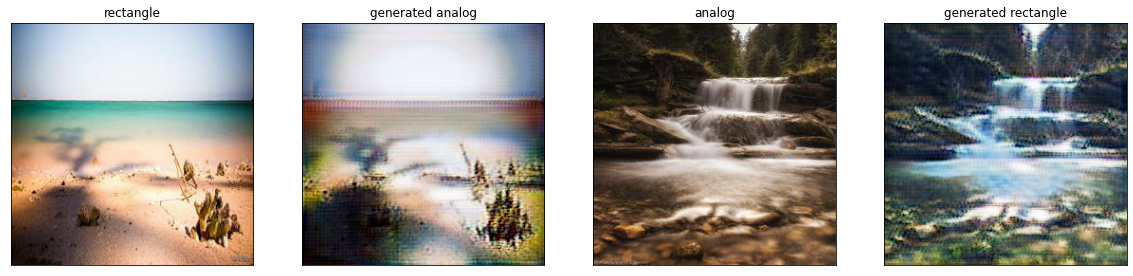

In [20]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("generated analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

#LOAD AN IMAGE AND CONVERT IT TO RECTANGULAR BY PATCHES

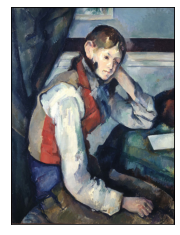

In [74]:
resize_x = 3
resize_y = 4
width = 256*resize_x
height = 256*resize_y
img=Image.open("for_patches.jpg").resize((256*resize_x,256*resize_y))

plt.imshow(np.array(img))
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

In [76]:
#prepare data
data=[]
for i in range(resize_y):
  for j in range(resize_x):
    patch = np.array(img)[i*256:(i+1)*(256),j*256:(j+1)*(256)]
    patch = np.moveaxis(patch,-1,0)
    data.append(torch.Tensor(patch).cpu())
    data[-1]=data[-1].to(torch.device("cuda:0"))
    
    print("image from ",i*256,",",j*256," to ",(i+1)*(256),",",(j+1)*(256)," shape : ",data[-1].shape,"and type : ",type(data[-1]))

image from  0 , 0  to  256 , 256  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  0 , 256  to  256 , 512  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  0 , 512  to  256 , 768  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  256 , 0  to  512 , 256  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  256 , 256  to  512 , 512  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  256 , 512  to  512 , 768  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  512 , 0  to  768 , 256  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  512 , 256  to  768 , 512  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  512 , 512  to  768 , 768  shape :  torch.Size([3, 256, 256]) and type :  <class 'torch.Tensor'>
image from  768 , 0  to  1024 , 256  sha

In [77]:
#pass the patches through the network
patches = []

for patch in data:
    patches.append(np.moveaxis(np.array(gen_S(patch).cpu().detach()),0,-1))

In [78]:
#stick the patches together into a new image
#reconstruct lines and stick them together
lines=[]
for i in range(resize_y):
  line=patches[i*resize_x]
  for j in range(1,resize_x):
    print(line.shape, "concatenated to : ",patches[i*resize_x+j].shape)
    line= np.concatenate([line,patches[i*resize_x+j]],axis=1)
  print("result : ",line.shape)
  lines.append(line)
img = lines[0]
for i in range(1,resize_y):
  print(img.shape, "concatenated to : ",lines[i].shape)
  img = np.concatenate([img,lines[i]],axis=0)
  print("result : ",img.shape)

(256, 256, 3) concatenated to :  (256, 256, 3)
(256, 512, 3) concatenated to :  (256, 256, 3)
result :  (256, 768, 3)
(256, 256, 3) concatenated to :  (256, 256, 3)
(256, 512, 3) concatenated to :  (256, 256, 3)
result :  (256, 768, 3)
(256, 256, 3) concatenated to :  (256, 256, 3)
(256, 512, 3) concatenated to :  (256, 256, 3)
result :  (256, 768, 3)
(256, 256, 3) concatenated to :  (256, 256, 3)
(256, 512, 3) concatenated to :  (256, 256, 3)
result :  (256, 768, 3)
(256, 768, 3) concatenated to :  (256, 768, 3)
result :  (512, 768, 3)
(512, 768, 3) concatenated to :  (256, 768, 3)
result :  (768, 768, 3)
(768, 768, 3) concatenated to :  (256, 768, 3)
result :  (1024, 768, 3)


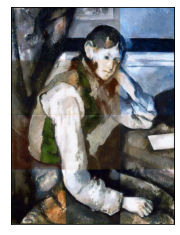

In [79]:
plt.imshow(img)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)